# Introduction

## About

## Table of Contents

## Notebook Setup

In [1]:
# Reload custom modules when modified
%load_ext autoreload
%autoreload 2

In [2]:
# Import common libraries
import torch
import numpy as np
from scipy.stats import ortho_group
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Custom notebook setup
%run setup_notebook.py

- adding project root in Python path
- setting default torch dtype to float64
- overriding matplotlib aesthetics


In [4]:
# Load project modules
from src.inference import compute_logdet
from src.utils import compute_logdet_bounds
from src.kernel import SquaredExponentialKernel, MaternKernel

In [5]:
# For figure labelization
param_map = {
    'lengthscale': 'l', 'nu': r'\nu'
}

def get_kernel_label(name, params):
    label_params = ', '.join(f'{param_map[param]}={value}' for param, value in params.items())
    label = f'{name} ${label_params}$'
    return label

---

# Overview of Kernel Functions and Kernel Matrices

## Sampling Functions from the Prior

We briefly explore how the choice of a kernel induces a prior distribution and the different shapes of the priors with different kernels.

The prior Gaussian Process is just the multivariate normal distribution with the kernel matrix as the covariance, since there is no data to condition the distribution on. With $x_i^\star$ the test points,

$$\mathbf y^\star \sim \mathcal N(\mathbf 0, K_{XX}), \quad (K_{XX})_{ij} = k(x_i, x_j)$$

In [7]:
# Kernels to compare
kernels = [
    # | --- class object ---| |-- name -|  |-- parameters ----|
    #(SquaredExponentialKernel, 'SE',     {'lengthscale': 0.1}),
    (SquaredExponentialKernel, 'SE',     {'lengthscale': 0.25}),
    (MaternKernel,             'Matern', {'lengthscale': 0.25, 'nu': 0.5}),
    (MaternKernel,             'Matern', {'lengthscale': 0.25, 'nu': 1.5}),
    (MaternKernel,             'Matern', {'lengthscale': 0.25, 'nu': 2.5})
]

In [6]:
from sklearn.gaussian_process.kernels import Matern
from sklearn.metrics import pairwise_distances

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


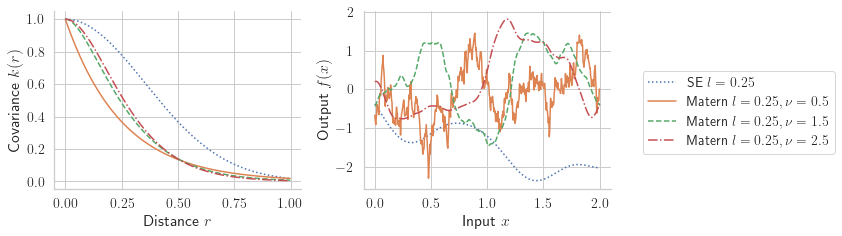

In [80]:
n = 500
x = torch.linspace(0, 2, n)
sigma2 = 0.05

_, ax = plt.subplots(1, 2, figsize=(12, 3.5))
ls = [':', '-', '--', '-.']
for i, (kernel, desc, params) in enumerate(kernels):
    # Plot covariance
    p = torch.tensor([sigma2, *params.values()])
    K = kernel(x).compute_kernel(p)
    ax[0].plot(x[:int(n/2)], K[:int(n/2), 0], label=get_kernel_label(desc, params), ls=ls[i])
    
    # Sample prior
    f = np.random.multivariate_normal(mean=np.zeros(n), cov=K)
    plt.plot(x, f, ls=ls[i], label=get_kernel_label(desc, params))
    
ax[0].set_xlabel('Distance $r$')
ax[0].set_ylabel('Covariance $k(r)$')
ax[1].set_xlabel('Input $x$')
ax[1].set_ylabel('Output $f(x)$')
plt.legend(bbox_to_anchor=(1.1, .7));
process_figure('covariance_overview')

## Eigenvalues of the Kernel Matrix

In [9]:
from src.kernel import SquaredExponentialKernel, MaternKernel

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


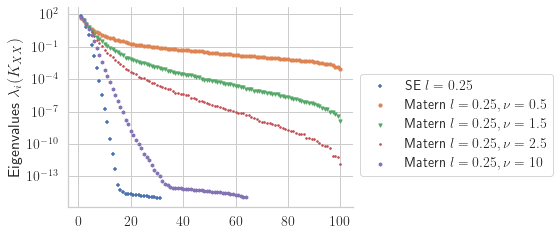

In [23]:
n = 100
x = torch.rand(n, 1)
sigma2 = 0.01

kernels = [
    # | --- class object ---| |-- name -|  |-- parameters ----|
    #(SquaredExponentialKernel, 'SE',     {'lengthscale': 0.1}),
    (SquaredExponentialKernel, 'SE',     {'lengthscale': 0.25}),
    (MaternKernel,             'Matern', {'lengthscale': 0.25, 'nu': 0.5}),
    (MaternKernel,             'Matern', {'lengthscale': 0.25, 'nu': 1.5}),
    (MaternKernel,             'Matern', {'lengthscale': 0.25, 'nu': 2.5}),
    (MaternKernel,             'Matern', {'lengthscale': 0.25, 'nu': 10}),
]

markers = ['+', 'o', 'v', '.', 'h']
plt.figure(figsize=(8, 3.5))
for i, (kernel, desc, params) in enumerate(kernels):
    K = kernel(x).compute_kernel(torch.tensor([sigma2, *params.values()]))
    
    threhsold = 1e-15
    e = torch.linalg.eigvalsh(K)
    e = np.array(e)[::-1]
    e[e < threhsold] = 0.0
    
    plt.scatter(range(1, len(e)+1), e, marker=markers[i], s=10, label=get_kernel_label(desc, params))
    
plt.yscale('log')
#plt.xscale('log')
plt.xlabel('')
plt.ylabel('Eigenvalues $\lambda_i(K_{XX})$')
plt.legend(bbox_to_anchor=(1., .7));
process_figure('kernel_eigenvalues')
#plt.xlim([0, 100])

In [160]:
n = 1000
sigma2 = 0.1

kernels = [
    # | --- class object ---| |-- name -|  |-- parameters ----|
    #(SquaredExponentialKernel, 'SE',     {'lengthscale': 0.1}),
    (SquaredExponentialKernel, 'SE',     {'lengthscale': 0.25}),
    (MaternKernel,             'Matern', {'lengthscale': 0.25, 'nu': 1.5})
]

data = [
    ('Uniform', torch.rand),
    ('Gaussian', torch.randn)
]
reps = 5
results = []
# Loop over the data distributions
for ax, (desc, gen_data) in zip(axes, data):
    ax[0].set_ylabel(desc)
    
    # Loop over the kernels
    for i, (kernel, desc_kernel, params) in enumerate(kernels):
        # Loop over the data dimension
        for j, d in enumerate((1, 2, 3, 4)):
            # Loop over repetitions of random sampling
            for _ in range(reps):
                x = gen_data(n, d)
                K = kernel(x).compute_kernel(torch.tensor([sigma2, *params.values()]))
                eigs = torch.linalg.eigvalsh(K)
                results.append({
                    'data': desc, 'kernel': desc_kernel, 'd': d, 'eigs': eigs.numpy()
                })

In [161]:
import pandas as pd
df = pd.DataFrame(results)
df

,data,kernel,d,eigs
0,Uniform,SE,1,"[-9.181676349836833e-14, -4.614538333098301e-1..."
1,Uniform,SE,1,"[-1.7389359213006268e-13, -6.700668989705753e-..."
2,Uniform,SE,1,"[-1.1020123063283344e-13, -7.703592838063428e-..."
3,Uniform,SE,1,"[-1.3994877389442934e-13, -9.319970685543767e-..."
4,Uniform,SE,1,"[-1.519025604711472e-13, -4.742850005186205e-1..."
...,...,...,...,...
75,Gaussian,Matern,4,"[0.02311182560691516, 0.20768624886898404, 0.2..."
76,Gaussian,Matern,4,"[0.1521654483071844, 0.1631442587731041, 0.180..."
77,Gaussian,Matern,4,"[0.062332269416054055, 0.09328818060885985, 0...."
78,Gaussian,Matern,4,"[0.08668382952006097, 0.11190288323889797, 0.1..."


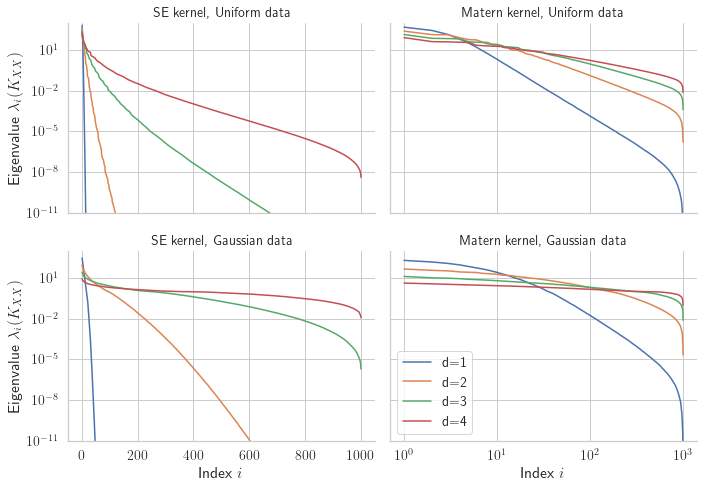

In [168]:
_, ax = plt.subplots(2, 2, figsize=(10, 7), sharey=True, sharex='col')

kernels = ['SE', 'Matern']
dists = ['Uniform', 'Gaussian']

artists = []
for i, k in enumerate(kernels):
    for j, dist in enumerate(dists):
        for d in range(1,5):
            sub = df[(df.data==dist) & (df.kernel==k) & (df.d==d)]
            eigs = np.stack(sub.eigs)[:, ::-1]
            indices = np.arange(1, eigs.shape[1]+1)
            a = ax[j, i]
            mu, sd = eigs.mean(axis=0), eigs.std(axis=0)
            a.semilogy(indices, mu, label=f'd={d}')
            #a.fill_between(indices, mu, mu-sd, mu+sd)
            a.set_title(f'{k} kernel, {dist} data')
            a.set_ylim((1e-11, 1e3))
            if k == 'Matern':
                a.set_xscale('log')

for a in ax[-1, :]: a.set_xlabel('Index $i$')
for a in ax[:, 0]: a.set_ylabel('Eigenvalue $\lambda_i(K_{XX})$')
plt.legend()
plt.tight_layout()
process_figure('kernel_eigvals')

---

# Preconditionning the kernel matrix

Some kernel matrices are extremely ill-conditionned, so that computing their eigenvalues with standard algorithms will fail, as shown by the example below:

In [11]:
from src.precond import PartialCholesky
from src.kernel import SquaredExponentialKernel, MaternKernel, Kernel

In [170]:
# Uniform grid on [0, 1] of n points
n = 100
x = torch.linspace(0., 1., n)

# Compute kernel matrix
lengthscale = 2.0
sigma2 = 0.1
K = SquaredExponentialKernel(x).compute_kernel(torch.tensor([sigma2, lengthscale]))

# Eigenvalues
eigs = torch.linalg.eigvalsh(K)
eigs.min()

tensor(-7.9759e-15)

Here, the computed minimum eigenvalue is $\tilde \lambda_{\min} < 0$, but we know that the true eigenvalue $\lambda_{\min} > 0$ since $K$ is SPD. Note that we won't work with $K$ directly but rather with $\widehat K := K + \sigma^2 I$, which is a very good news since $\widehat K$ is much better conditionned. However, we will rely on Lanczos algorithm to approximate some quantities, and we need the number of Lanczos steps to scale with the square root of the condition number. Therefore, we wish to accelerate the convergence of Lanczos.


We explore how the condition number of the preconditionned matrix 

$$ \widehat P^{-\frac 1 2}_k \widehat K_{XX} \widehat P^{-\frac 1 2}_k$$

behaves as a function of $k := \text{rank}(P_k)$ with $P_k = L_kL_k^\top \approx K_{XX}$. We can relate this condition number to the trace of the low-rank approximation, which itself is upper bounded by a scaling of $\Gamma_k \lambda_k(K_{XX})$

## Monitor Growth Factor

In pivoted cholesky, we have the relationship

$$\text{Trace}(K_{XX} - L_kL_k^\top) \le nC \Gamma_k \lambda_k(K_{XX}) \; .$$

We wish to monitor the upper bound $\Gamma_k \lambda_k(K_{XX})$ with different data distributions and choices of the kernel. 

In [168]:
def compute_gamma(L, k):
    """
    Compute the gamma factor
    :param L: lower triangular matrix, i.e. pivoted cholesky factor Lk after permutation
    :param k: the number of columns of k to consider
    :param pivot_lkk: the kth pivot element of pivoted Cholesky
    """
    l_kk = L[k, k]
    L11 = L[:k, :k]
    norm = torch.linalg.norm(torch.linalg.inv(L11))
    gamma = l_kk**2 * norm**2
    eig_A11 = 1 / norm**2
    return gamma, eig_A11

Pathological case: triangular matrix with -1 on digonal, we get $\Gamma_k = \mathcal O(4^k)$

In [169]:
n = 1000
T = torch.randn(n, n)
T = torch.tril(T)
# Put -1 on diagonal
T -= torch.diag(T.diag(-1) + 1,-1)
# Jitter to bring diagonal away from zero
T += torch.eye(n) * 0.01

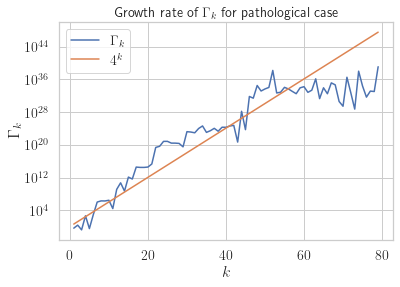

In [170]:
ks = np.arange(1,80)
pathological_gamma = [compute_gamma(T, k)[0] for k in ks]
plt.semilogy(ks, pathological_gamma, label='$\Gamma_k$')
plt.semilogy(ks, 4.**ks, label='$4^k$')

plt.xlabel('$k$'); plt.ylabel('$\Gamma_k$');
plt.title('Growth rate of $\Gamma_k$ for pathological case')
plt.legend();

## Run experiments



In [176]:
from time import perf_counter

def compute_pivchol(n, d, data_fun, data_descriptor, kernel_class, kernel_descriptor, kernel_params, sigma2, max_rank):
    x = data_fun(n, d)
    
    params = torch.concat([torch.tensor([sigma2]), torch.tensor(kernel_params)])
    start = perf_counter()
    kernel = kernel_class(x)
    kernel.compute_kernel(params)
    time_kernel = perf_counter() - start
    
    start = perf_counter()
    P = PartialCholesky(kernel.K, max_rank=max_rank, sigma2=sigma2)
    time_pivchol = perf_counter() - start
    
    eigs_kernel = torch.linalg.eigvalsh(kernel.K).numpy()[::-1]
    
    results = {
        'data': data_descriptor,
        'd': d,
        'kernel': kernel_descriptor,
        'max_rank': max_rank,
        'rank': P.k,
        'kernel_eigs': eigs_kernel,
        'kernel_params': kernel_params,
        'pivchol_trace': P.trace_errors.numpy(),
        'sigma2': sigma2,
        'time_kernel': time_kernel,
        'time_pivchol': time_pivchol
    }
    
    return results, kernel, P

In [177]:
def compute_pivchol_quantities(kernel: Kernel, P: PartialCholesky, k_stride=None):
    maxrank = P.k
    if k_stride is None:
        if maxrank <= 30:
            k_stride = 1
        elif maxrank <= 50:
            k_stride = 2
        elif maxrank <= 100:
            k_stride = 5
        else:
            k_stride = 10
    
    results = []
    ks = list(range(1, maxrank, k_stride))
    ks.append(maxrank-1)
    L = P.Lk[P.pivots]
    Khat = kernel.Khat()
    for k in ks:
        gamma, eigA11 = compute_gamma(L, k)
        
        Pk = P.truncate(k)
        precond_eigs = Pk.compute_precond_eigs()
        cond = precond_eigs.max() / precond_eigs.min()
        
        results.append({
            'k': k,
            'gamma': gamma.item(),
            'eig_A11': eigA11.item(),
            'cond': cond.item()
        })
    
    return results

In [179]:
%%time

# ======== WARNING ======== 
# Running this cell requires a lot of time, the results are saved in the following cell
# Load the results from disk if you just want to see the results


n = 1000
ds = (1, 2, 3, 4)
repetitions = 5
max_rank = 300
data = [
    ('normal', torch.randn),
    ('uniform', torch.rand)
]
sigma2, lengthscale, nu = 0.1, 0.1, 2.5
kernels = [
    ('SE', SquaredExponentialKernel, (lengthscale,)), 
    ('Matern', MaternKernel, (lengthscale, nu))
]


results = []
results_qtties = []
# Loop over configurations
for desc_kernel, kernel_class, hyperparams in kernels:
    for desc_data, data_fun in data:
        for d in ds:
            print(f'{desc_kernel} {desc_data} d={d}', end=', ')
            
            # Repeat experiments
            for r in range(repetitions):
                res, kernel, P = compute_pivchol(n, d, data_fun, desc_data, kernel_class, 
                                                 desc_kernel, hyperparams, sigma2, max_rank)
                res['r'] = r
                results.append(res)
                
                res = compute_pivchol_quantities(kernel, P)
                # Add information
                for i in range(len(res)):
                    res[i].update({
                        'kernel': desc_kernel,
                        'data': desc_data,
                        'd': d,
                        'r': r
                    })
                results_qtties.extend(res)

SE normal d=1, SE normal d=2, SE normal d=3, SE normal d=4, SE uniform d=1, SE uniform d=2, SE uniform d=3, SE uniform d=4, Matern normal d=1, Matern normal d=2, Matern normal d=3, Matern normal d=4, Matern uniform d=1, Matern uniform d=2, Matern uniform d=3, Matern uniform d=4, CPU times: user 2h 2min 8s, sys: 29.8 s, total: 2h 2min 38s
Wall time: 34min 13s


In [180]:
import pandas as pd

df = pd.DataFrame(results)
df

,data,d,kernel,max_rank,rank,kernel_eigs,kernel_params,pivchol_trace,sigma2,time_kernel,time_pivchol,r
0,normal,1,SE,300,74,"[205.79392879808046, 165.07046077255671, 136.4...","(0.1,)","[850.7384088734743, 828.1420439162749, 810.130...",0.1,0.030770,2.315671,0
1,normal,1,SE,300,73,"[209.08151905271643, 159.93213994711374, 126.6...","(0.1,)","[980.7943803257332, 818.2337704333167, 774.955...",0.1,0.016406,2.265838,1
2,normal,1,SE,300,74,"[208.95738261872907, 166.55551914853197, 128.3...","(0.1,)","[874.4092411387657, 870.0704935739772, 739.273...",0.1,0.004512,2.277218,2
3,normal,1,SE,300,76,"[192.74795270729862, 157.92396271046476, 131.9...","(0.1,)","[870.5903238734561, 830.8018271670721, 828.819...",0.1,0.004448,2.472610,3
4,normal,1,SE,300,75,"[191.23396333728755, 168.11996654528656, 127.0...","(0.1,)","[861.0981342215428, 837.6708806019864, 765.041...",0.1,0.020442,2.449532,4
...,...,...,...,...,...,...,...,...,...,...,...,...
75,uniform,4,Matern,300,300,"[5.728995701126023, 5.366613018805285, 5.13666...","(0.1, 2.5)","[997.6676242247424, 996.2494166932646, 994.823...",0.1,0.179661,8.301116,0
76,uniform,4,Matern,300,300,"[6.1244111380427135, 5.186199555004068, 5.0368...","(0.1, 2.5)","[998.8105327799929, 996.9415723696007, 995.824...",0.1,0.182429,8.277572,1
77,uniform,4,Matern,300,300,"[5.809177222371379, 5.277847934733645, 4.99245...","(0.1, 2.5)","[998.7801820343172, 997.2699629333968, 996.128...",0.1,0.178833,8.418711,2
78,uniform,4,Matern,300,300,"[5.411548910369655, 5.032662359598071, 4.72014...","(0.1, 2.5)","[998.0667078430533, 995.9823898477591, 994.273...",0.1,0.178298,8.302454,3


In [181]:
df2 = pd.DataFrame(results_qtties)
df2

,k,gamma,eig_A11,cond,kernel,data,d,r
0,1,1.000000,1.000000,1855.359038,SE,normal,1,0
1,6,5.999910,0.166667,1719.231951,SE,normal,1,0
2,11,9.925502,0.090789,972.325361,SE,normal,1,0
3,16,12.570966,0.053448,384.141551,SE,normal,1,0
4,21,6.938420,0.032183,154.941121,SE,normal,1,0
...,...,...,...,...,...,...,...,...
2321,261,256.932646,0.003773,29.463873,Matern,uniform,4,4
2322,271,266.377478,0.003627,26.374143,Matern,uniform,4,4
2323,281,276.244429,0.003492,23.382529,Matern,uniform,4,4
2324,291,285.854084,0.003366,23.378935,Matern,uniform,4,4


In [182]:
df_plot = df2.set_index(['kernel', 'data', 'd', 'r'])
df_plot = df_plot.join(df.set_index(['kernel', 'data', 'd', 'r']))
df_plot.kernel_eigs = df_plot.apply(lambda row: row.kernel_eigs[row.k], axis=1)
df_plot.pivchol_trace = df_plot.apply(lambda row: row.pivchol_trace[row.k], axis=1)
df_plot.reset_index(inplace=True)
df_plot['prod'] = df_plot.gamma * df_plot.kernel_eigs

df_plot.to_csv('data/pivoted_cholesky.csv')
df_plot

,kernel,data,d,r,k,gamma,eig_A11,cond,max_rank,rank,kernel_eigs,kernel_params,pivchol_trace,sigma2,time_kernel,time_pivchol,prod
0,Matern,normal,1,0,1,1.000000,1.000000,929.608004,300,300,77.327770,"(0.1, 2.5)",909.441528,0.1,0.204555,8.920182,77.327770
1,Matern,normal,1,0,11,10.999869,0.090909,705.763796,300,300,31.304980,"(0.1, 2.5)",687.302813,0.1,0.204555,8.920182,344.350680
2,Matern,normal,1,0,21,20.637907,0.047168,549.634015,300,300,11.654137,"(0.1, 2.5)",463.512790,0.1,0.204555,8.920182,240.516990
3,Matern,normal,1,0,31,21.842613,0.030587,299.529398,300,300,4.646249,"(0.1, 2.5)",283.772595,0.1,0.204555,8.920182,101.486229
4,Matern,normal,1,0,41,30.743004,0.017467,109.296803,300,300,2.389742,"(0.1, 2.5)",130.523988,0.1,0.204555,8.920182,73.467858
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2321,SE,uniform,4,4,261,179.785197,0.001015,7.313044,300,300,0.260121,"(0.1,)",69.100105,0.1,0.013667,9.109783,46.765891
2322,SE,uniform,4,4,271,185.370082,0.000910,6.789129,300,300,0.234329,"(0.1,)",63.346001,0.1,0.013667,9.109783,43.437594
2323,SE,uniform,4,4,281,193.622258,0.000825,6.441629,300,300,0.210711,"(0.1,)",57.010480,0.1,0.013667,9.109783,40.798261
2324,SE,uniform,4,4,291,195.660251,0.000746,5.576443,300,300,0.190024,"(0.1,)",52.738779,0.1,0.013667,9.109783,37.180212


In [192]:
df_plot.gamma.min()

0.0701423113379901

In [183]:
df_plot = pd.read_csv('data/pivoted_cholesky.csv')

## Gamma factor

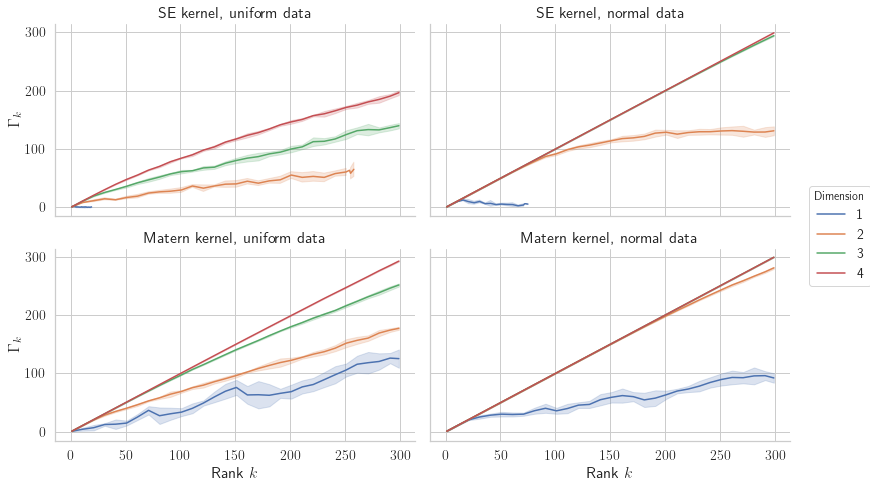

In [202]:
grid = sns.relplot(x='k', y='gamma', hue='d', data=df_plot, palette='deep', 
                   ci='sd', row='kernel', col='data', kind='line', col_order=('uniform', 'normal'),
                   aspect=1.5, row_order=('SE', 'Matern'), height=3.5)

grid.set_axis_labels('Rank $k$', '$\Gamma_k$')
grid.set_titles('{row_name} kernel, {col_name} data')
grid._legend.set_frame_on(True)
grid._legend.set_bbox_to_anchor((1.08,0.5))
grid._legend.set_title('Dimension')

process_figure('pivchol_gamma')

## Trace of error matrix

In [207]:
print(r'\trace')

\trace


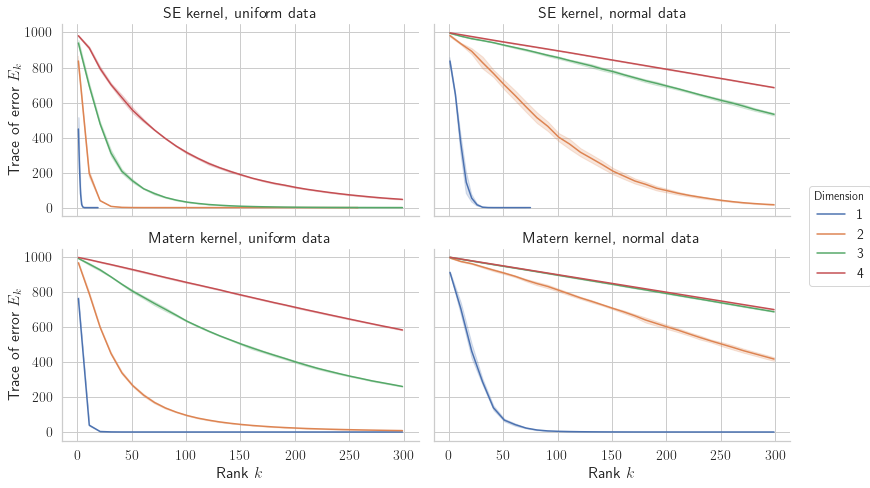

In [214]:
grid = sns.relplot(x='k', y='trace', hue='d', data=df_plot.rename(columns={'pivchol_trace': 'trace'}), palette='deep', 
                   ci='sd', row='kernel', col='data', kind='line', col_order=('uniform', 'normal'),
                   aspect=1.5, row_order=('SE', 'Matern'), height=3.5)

grid.set_axis_labels('Rank $k$', r'Trace of error $E_k$')
grid.set_titles('{row_name} kernel, {col_name} data')
grid._legend.set_frame_on(True)
grid._legend.set_bbox_to_anchor((1.08,0.5))
grid._legend.set_title('Dimension')
process_figure('pivchol_trace')

## Upper bound

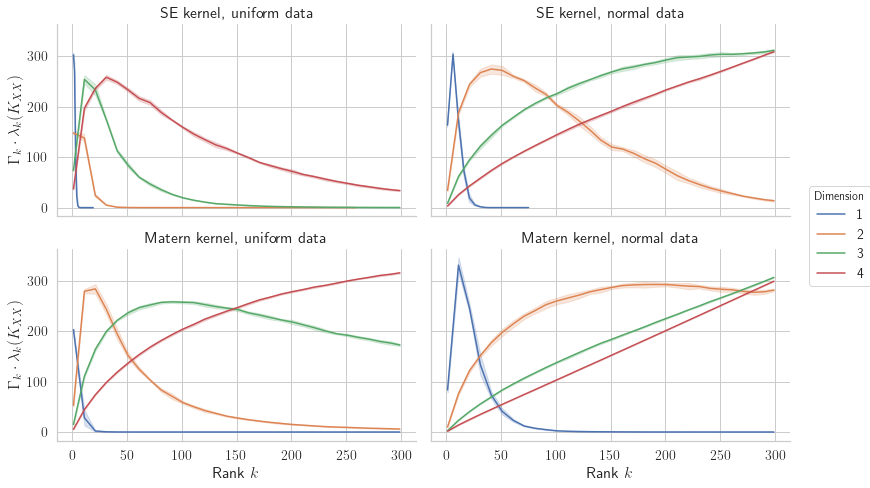

In [217]:
grid = sns.relplot(x='k', y='prod', hue='d', data=df_plot, palette='deep', 
                   ci='sd', row='kernel', col='data', kind='line', col_order=('uniform', 'normal'),
                   aspect=1.5, row_order=('SE', 'Matern'), height=3.5)

grid.set_axis_labels('Rank $k$', '$\Gamma_k \cdot \lambda_k(K_{XX})$')
grid.set_titles('{row_name} kernel, {col_name} data')
grid._legend.set_frame_on(True)
grid._legend.set_bbox_to_anchor((1.08,0.5))
grid._legend.set_title('Dimension')
process_figure('pivchol_upperbound')

## Pivoted Cholesky as Preconditioning Technique


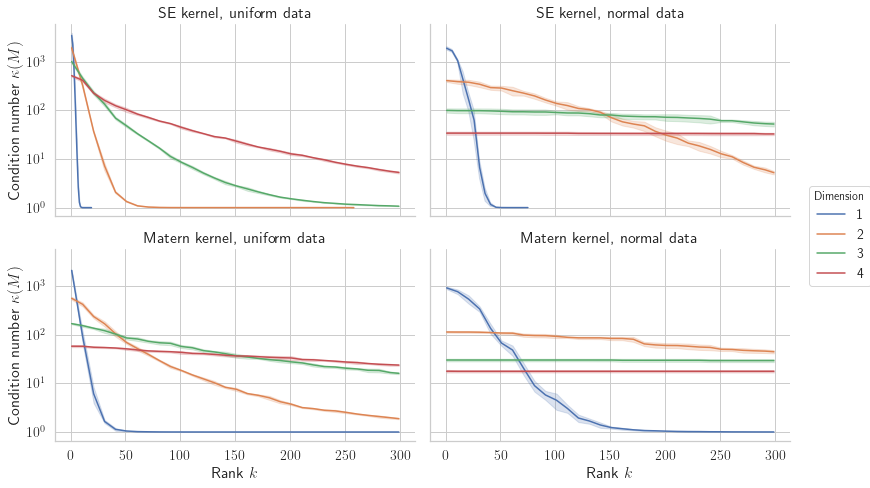

In [216]:
grid = sns.relplot(x='k', y='cond', hue='d', data=df_plot, palette='deep', 
                   ci='sd', row='kernel', col='data', kind='line', col_order=('uniform', 'normal'),
                   aspect=1.5, row_order=('SE', 'Matern'), height=3.5)

plt.yscale('log')
grid.set_axis_labels('Rank $k$', 'Condition number $\kappa(M)$')
grid.set_titles('{row_name} kernel, {col_name} data')
grid._legend.set_frame_on(True)
grid._legend.set_bbox_to_anchor((1.08,0.5))
grid._legend.set_title('Dimension')
process_figure('pivchol_cond')

---

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


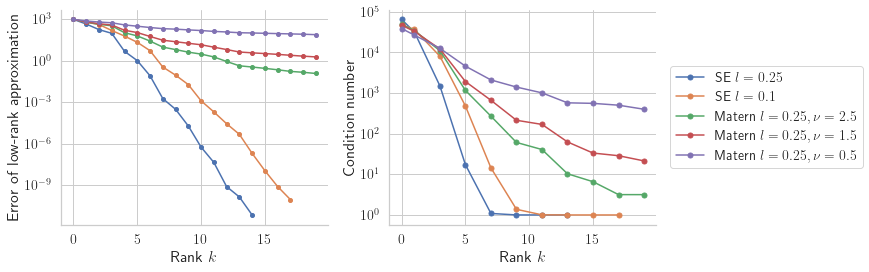

In [81]:
_, ax = plt.subplots(1, 2, figsize=(13, 4), sharex=True)

for i, (kernel, name, params) in enumerate(kernels):
    label = get_kernel_label(name, params)
    ks_cond_nums = list([0] + list(ks_explore))[:len(cond_nums[i])]
    ks_trerr = range(len(trace_errors[i]))
    ax[1].semilogy(ks_cond_nums, cond_nums[i], '-o', label=label, markersize=5)
    ax[0].semilogy(ks_trerr, trace_errors[i], '-o', label=label, markersize=4)
    
# Aesthetics
for a in ax: a.set_xlabel('Rank $k$')
ax[1].set_ylabel('Condition number')
ax[0].set_ylabel('Error of low-rank approximation')
plt.legend(bbox_to_anchor=(1.8, .5), loc='center right')
# Save figure
process_figure('kernel_preconditionning_1d_stdnormal')

# mBCG on kernel matrices

In [21]:
from src.cg import mbcg

In [22]:
def callback(error_lst, xtrue):
    """
    Helper callback function: iterative methods (e.g, CG) can be provided a callback function,
    i.e. a function that will be called at each step of the iterative method with the input
    being the current solution. 
    This helper function provides a concise way of measuring the relative error at each step.
    
    :param error_lst: the list in which relative errors will be stored at each step
    :param xtrue: the true solution used to compute the error
    """
    xtrue_norm = (xtrue ** 2).sum() ** 0.5
    def inner(xk):
        """Wrapped function. `inner` will be called by the iterative methhod."""
        error_stepk = xk - xtrue
        # Compute relative error
        error_stepk = (error_stepk ** 2).sum() ** 0.5 / xtrue_norm
        error_lst.append(error_stepk)
        
    return inner

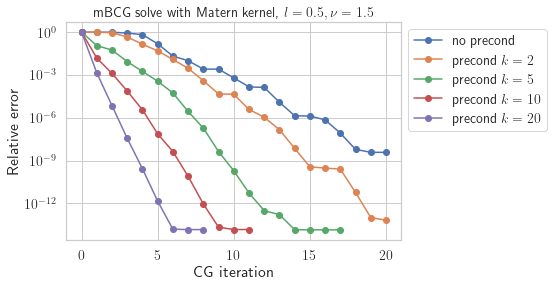

In [23]:
# Build the kernel matrix
n = 1000
sigma2 = 1
lengthscale = 0.5
nu = 1.5

grid = torch.linspace(0, 1, n)
K = MaternKernel(grid).compute_kernel(torch.tensor([sigma2, lengthscale, nu]))
Khat = K + torch.eye(n) * sigma2

# Build the system Ax = b
xtrue = torch.randn(n)
b = Khat @ xtrue

# Solve without preconditionning
k = 20
rel_errs = []
mbcg(lambda X: Khat @ X, lambda X: X, b, torch.zeros(n), k=k, callback=callback(rel_errs, xtrue))
plt.semilogy(rel_errs, '-o', label='no precond')

# Solve with preconditionning
ranks = (2, 5, 10, 20)
for rank in ranks:
    # Compute preconditionner
    P = PartialCholesky(K, max_rank=rank, sigma2=sigma2)
    # Run mBCG
    rel_errs = []
    mbcg(lambda X: Khat @ X, P.inv_fun, b, torch.zeros(n), k=k, callback=callback(rel_errs, xtrue))
    # Plot
    plt.semilogy(rel_errs, '-o', label=f'precond $k={rank}$')

plt.xlabel('CG iteration'); plt.ylabel('Relative error')
plt.title(f'mBCG solve with Matern kernel, $l={lengthscale}, \\nu = {nu}$')
#plt.title('mBCG solve of $\widehat K_' + '_{XX}' + f' x=b$ with Matern kernel, $l={lengthscale}$')
plt.legend(bbox_to_anchor=(1,1));

---

# mBCG Quadrature Error

In this section we explore the error of Lanczos quadrature and the effect of preconditioning. Specifically, we analyze the error of this approximation

$$
\mathbf z^\top (\log M) \mathbf z \approx \Vert \mathbf z \Vert_2^2 \, \mathbf e_1^\top (\log T_m) \mathbf e_1
$$

where $T_m$ is the $m$-step partial Lanczos tridiagonalization of $M$ computed with mBCG. Recall that if we precondition mBCG, we virtually run Lanczos on the preconditioned matrix. Hence, the matrix $M$ used to compute the ground truth quadratic form is

$$
M := \widehat P_k^{-1/2} \widehat K_{XX} \widehat P_k^{-1/2}
$$

In [218]:
import pandas as pd
import scipy as sp
from src.precond import PartialCholesky
from src.quadrature import lanczos_quadrature
from src.cg import mbcg

## Numerical routines

In [376]:
SYMMETRIC_THRESHOLD = 1e-12

def symmetrize_result(fun):
    """Decorator to symmetrize output of a matrix function"""
    def inner(*args, **kwargs):
        res = fun(*args, **kwargs)
        error = (res - res.T).abs().max()
        if error > SYMMETRIC_THRESHOLD:
            print(f'WARNING: symmetry error abs(A - A^T) greater than {SYMMETRIC_THRESHOLD} for the function {fun.__name__}')
        
        return (res + res.T) / 2

    return inner

@symmetrize_result
def logm_spd(A: torch.Tensor) -> torch.Tensor:
    """Matrix logarithm for A SPD."""
    return torch.from_numpy(sp.linalg.logm(A))

@symmetrize_result
def sqrt_spd(A: torch.Tensor) -> torch.Tensor:
    """Matrix square root for A SPD."""
    return torch.from_numpy(sp.linalg.sqrtm(A))

## Without preconditioning

We first check the consistency of Lanczos quadrature without preconditioning. We use random vectors, but note that the error is not due to randomness here.

In [368]:
# Generate data, compute kernel
n, d = 1000, 1
x = torch.randn(n, d)
k = SquaredExponentialKernel(x)

sigma2, lengthscale = 0.1, 0.1
k.compute_kernel(torch.tensor([sigma2, lengthscale]))

# Compute logarithm of Khat
logKhat = logm_spd(k.Khat())
assert (logKhat - logKhat.T).abs().max() < symmetric_threshold
logKhat = (logKhat + logKhat.T) / 2

In [369]:
# Sanity check, for SPD matrices, logdet is trace log
(logKhat.trace() - torch.logdet(k.Khat())).abs()

tensor(4.5475e-13)

In [337]:
# Probe vectors
N = 100
Z = torch.randn(n, N)

# Compute exact quadratic forms with explicit matrix logarithm
true_quad = ((Z.T @ logKhat) * Z.T).sum(dim=1)

# Run mBCG
m = 10
_, Ts = mbcg(k.Khat_fun, lambda x: x, Z, torch.zeros_like(Z), k=m)

# Lanczos quadrature, loop over all probe vectors
quad = torch.tensor([
    lanczos_quadrature(torch.log, Ts[i], Z[:, i], n)
    for i in range(N)
])

relerrs = ((true_quad - quad) / true_quad).abs()
relerrs.mean(), relerrs.std()

(tensor(0.0152), tensor(0.0043))

We now put this in a loop, and monitor number of iterations for some fixed tolerance. If we have several probe vectors, mBCG continues until the residuals of all solutions drop below the tolerance. Hence the number of iterations will be the same for all probe vectors, and we have to run mBCG separately on each probe vector to average the number of iterations.

In [338]:
tolerances = 10. ** (-np.arange(1, 10 + 1))
N = 10
max_iter = 1000

results = []
for tol in tolerances:
    Z = torch.randn(n, N)
    # Repeat experiment for several probe vectors
    for z in Z.T:
        _, (T,) = mbcg(k.Khat_fun, lambda x: x, z, torch.zeros_like(z), k=max_iter, tol=tol)
        
        num_iter = T.shape[0]
        true_quadrature = z.T @ logKhat @ z
        quadrature = lanczos_quadrature(f=torch.log, Tm=T, z=z, matrix_size=n)
        error_quadrature = ((true_quadrature - quadrature) / true_quadrature).abs().item()
        
        results.append({
            'k': 0, # this is the rank of the preconditioner, means we don't precondition
            'tol': tol,
            'iter': num_iter,
            'error': error_quadrature
        })

In [339]:
df = pd.DataFrame(results)
df

,k,tol,iter,error
0,0,1.000000e-01,24,8.134168e-05
1,0,1.000000e-01,23,1.044824e-04
2,0,1.000000e-01,23,6.989645e-05
3,0,1.000000e-01,22,1.387816e-04
4,0,1.000000e-01,20,1.670571e-04
...,...,...,...,...
95,0,1.000000e-10,92,2.906678e-15
96,0,1.000000e-10,92,1.646985e-15
97,0,1.000000e-10,92,5.189041e-15
98,0,1.000000e-10,93,1.307799e-15


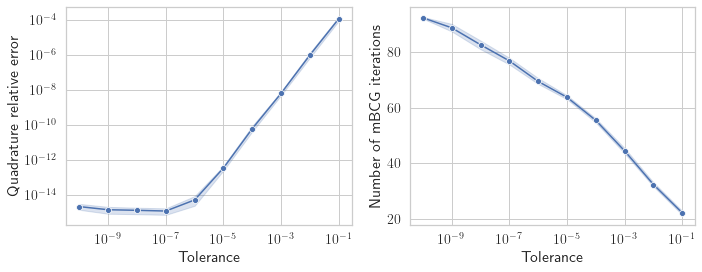

In [340]:
_, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.lineplot(x='tol', y='error', data=df, marker='o', ax=ax[0])
sns.lineplot(x='tol', y='iter', data=df, marker='o', ax=ax[1])

ax[0].set_xscale('log'); ax[1].set_xscale('log'); ax[0].set_yscale('log')
# Aesthetics
ax[0].set_xlabel('Tolerance'); ax[0].set_ylabel('Quadrature relative error')
ax[1].set_xlabel('Tolerance'); ax[1].set_ylabel('Number of mBCG iterations')
plt.tight_layout()

## With preconditioning


### Groundtruth quadratic forms

We first explicitly compute the SPD preconditioned matrix $\widehat P_k^{-1/2} \widehat K_{XX} \widehat P_k^{-1/2}$ to monitor the error. We have to rely on explicit computation of the square root $\widehat P_k^{1/2}$. We apply symmetrization when some oeprations destroy the symmetry to reduce propagation of errors. 

In [383]:
def compute_precond_mx(k, P, symmetric_threshold=1e-13):
    # Square root of preconditioner
    Phat_sqrt = sqrt_spd(P.Pk_hat())
    # sqrtm returns complex -> convert to real
    Phat_sqrt = Phat_sqrt.real
    
    # Apply inverse of P sqrt on the right
    Khat_times_Pinvsqrt = torch.linalg.solve(Phat_sqrt, k.Khat()).T
    # Apply inverse of P sqrt on the left
    M = torch.linalg.solve(Phat_sqrt, Khat_times_Pinvsqrt)
    # M should be symmetric
    error = (M - M.T).abs().max()
    if error > SYMMETRIC_THRESHOLD:
        print(f'Warning: threshold above {SYMMETRIC_THRESHOLD} for symmetry of preconditioned matrix')
        
    M = (M + M.T) / 2
    return M, Phat_sqrt

To check this implementation, compare the spectrum of $\widehat P_k^{-1/2} \widehat K_{XX} \widehat P_k^{-1/2}$ and $\widehat P_k^{-1} \widehat K_{XX}$, they should be the same. Computation of $\widehat P_k^{-1} \widehat K_{XX}$ relies on the Woordbury formula and is thus considered more accurate.

In [380]:
# Sanity check
P = PartialCholesky(k.K, max_rank=20, sigma2=sigma2)
M, Phat_sqrt = compute_precond_mx(k, P)

precond_eigvals = torch.linalg.eigvalsh(M).flip(0)
# P.compute_precond_eigs computes eigenvalues of Pinv K
error_eigvals = (precond_eigvals - P.compute_precond_eigs()).abs() / P.compute_precond_eigs()
error_eigvals.max()

tensor(6.6169e-13)

We compute the matrix logarithm of $\widehat P_k^{-1/2} \widehat K_{XX} \widehat P_k^{-1/2}$:

In [382]:
symmetric_threshold = 1e-13

logM = logm_spd(M)

# Sanity check: logdet is the trace log
(torch.logdet(M) - logM.trace()).abs()

tensor(7.5318e-13)

We sample vectors $\mathbf z_i \sim \mathcal N(\mathbf 0, \widehat P_k)$, run mBCG and compute Lanczos quadrature. Care must be taken to compare against groundtruth quadratic forms. Lanczos quadrature computes 

$$\Vert \mathbf z \Vert_2^2 \, \mathbf e_1^\top \log(T_m) \mathbf e_1$$

assuming that the starting vector of Lanczos is $\mathbf z$. However, if $T_m$ is obtained with mBCG using preconditioning, the starting vector of Lanczos is $\widehat P_k^{-1/2} \mathbf z$. Hence we run mBCG with $\mathbf z$ but compute Lanczos quadrature (and groundtruth) with preconditioned vectors $\widehat P_k^{-1/2} \mathbf z$.

In [345]:
# Sample probe vectors
N = 200
Z = P.sample_gaussian(N)

# Run CG
m = 200
X, Ts = mbcg(Afun=k.Khat_fun, Pinv=P.inv_fun, B=Z, X0=torch.zeros_like(Z), k=m)

# Precondition starting vector with P sqrt
Zprecond = torch.linalg.solve(Phat_sqrt, Z)

# Compute true quadratic forms
true_q = ((Zprecond.T @ logM) * Zprecond.T).sum(dim=1)

# Lanczos quadrature
q = torch.tensor([
    lanczos_quadrature(f=torch.log, Tm=Ts[i], z=Zprecond[:, i], matrix_size=n)
    for i in range(N)
])

In [346]:
# Sanity check: convergence of approx of K^-1 Z
# Maximal norm of error among all right-hand sides
(k.Khat_fun(X) - Z).norm(dim=0).max()

tensor(9.5763e-13)

In [347]:
(true_q - q).abs().max()

tensor(1.2278e-10)

### Numerical experiment 

The code works. We now vary:

* The data (distribution and dimension)
* The kernel
* The rank of the preconditioner (number of pivoted Cholesky steps)
* The tolerance of mBCG

In [458]:
def compute_quadrature_with_tolerances(kernel: Kernel, logA, z: torch.Tensor, tolerances, max_iter, P: PartialCholesky = None, Phat_sqrt = None):
    true_quad = z.T @ logA @ z
    
    relative_res = []
    callback = lambda res: relative_res.append(res)
    
    if P is None:
        pinvfun = lambda x: x
        zprecond = z
    else:
        pinvfun = P.inv_fun
        zprecond = torch.linalg.solve(Phat_sqrt, z)
    _, (T, ) = mbcg(kernel.Khat_fun, P)


def compute_quadrature(kernel: Kernel, Pmax: PartialCholesky, sample_probe, repeats: int, tolerances, config_description, max_iter):
    """Save computations by running mBCG with minimum tolerance,
    quantities for higher tolerances can be inferred a posteriori"""
    min_tol = min(tolerances)
    
    # For ground truth computation
    logKhat = logm_spd(kernel.Khat())
    
    results = []
    for r in range(repeats):
        z = sample_probe()
        true_quad = z.T @ logKhat @ z

        relative_residuals = []
        callback = lambda res: relative_residuals.append(res)
        _, (T,) = mbcg(kernel.Khat_fun, lambda x: x, z, torch.zeros_like(z), k=max_iter, tol=min_tol, callback_residuals=callback)

        # Recall the first element of relative_residuals is for the starting vector
        for tol in tolerances:
            # Find the iteration corresponding to the given tolerance, based on residuals
            num_iter = min(index for index, residuals in enumerate(relative_residuals) if residuals <= tol)
            # Truncate the tridiagonal matrix 
            T_truncated = T[:num_iter, :num_iter]

            quad = lanczos_quadrature(f=torch.log, Tm=T_truncated, z=z, matrix_size=logKhat.shape[0])
            error_quad = ( (quad-true_quad) / true_quad ).abs().item()

            results.append({
                **config_description,
                'k': 0,
                'tol': tol,
                'error': error_quad,
                'iter': num_iter,
                'r': r
            })
        
        for k in ks:
            P = Pmax.truncate(k)
            M, Phat_sqrt = compute_precond_mx(kernel, P)
            logM = logm_spd(M)
            zprecond = torch.linalg.solve(Phat_sqrt, z)
            true_quadrature = zprecond.T @ logM @ zprecond
            
            relative_residuals = []
        callback = lambda res: relative_residuals.append(res)
        _, (T,) = mbcg(kernel.Khat_fun, lambda x: x, z, torch.zeros_like(z), k=max_iter, tol=min_tol, callback_residuals=callback)


    return results

In [419]:
%%time
# Number of points
n = 1000
# Noise
sigma2 = 0.1
# Max mBCG iteration
max_iter = 500

tolerances = 10. ** (-np.arange(1, 10 + 1))
data = [
    ('uniform', torch.rand),
    ('normal', torch.randn)
]
dims = (1,2,3,4)

kernels = [
    # | --- class object ---| |-- name -|  |-- parameters ----|
    #(SquaredExponentialKernel, 'SE',     {'lengthscale': 0.1}),
    (SquaredExponentialKernel, 'SE',     {'lengthscale': 0.25}),
    (MaternKernel,             'Matern', {'lengthscale': 0.25, 'nu': 1.5}),
#    (SquaredExponentialKernel, 'SE',     {'lengthscale': 0.1}),
#    (MaternKernel,             'Matern', {'lengthscale': 0.1, 'nu': 1.5}),
]

repeats = 2

ranks = (2, 5, 10, 20, 30)

results = []
for data_desc, data_fun in data:
    for d in dims:
        for kernel_class, kernel_desc, kernel_params in kernels:
            print(f'{data_desc} data d={d}, {kernel_desc}', end='; ')
            # Sample data & compute kernel matrix
            x = data_fun(n, d)
            kernel = kernel_class(x)
            K = kernel.compute_kernel(torch.tensor([sigma2, *kernel_params.values()]))
            # Pivoted Cholesky of max rank
            Pmax = PartialCholesky(K, max_rank=max(ranks), sigma2=sigma2)
            
            # Compute quantities for groundtruth
            logKhat = torch.from_numpy(sp.linalg.logm(kernel.Khat()))
            logKhat = (logKhat + logKhat.T) / 2
            
            z = torch.randn(n)
            for k in ranks:
                # If pivoted cholesky converged earlier
                if k > Pmax.k:
                    break
                
                P = Pmax.truncate(k)
                M, Phat_sqrt = compute_precond_mx(kernel, P)
                logM = logm_spd(M)
                
                zprecond = torch.linalg.solve(Phat_sqrt, z)
                true_quadrature = zprecond.T @ logM @ zprecond
                
                for tol in tolerances:
                    _, (T, ) = mbcg(Afun=kernel.Khat_fun, Pinv=P.inv_fun, B=z, X0=torch.zeros_like(z), k=max_iter, tol=tol)
                    num_iter = T.shape[0]
                    quadrature = lanczos_quadrature(f=torch.log, Tm=T, z=zprecond, matrix_size=n)
                    error_quadrature = ((true_quadrature - quadrature) / true_quadrature).abs()
                    
                    results.append({
                        'data': data_desc,
                        'd': d,
                        'kernel': kernel_desc,
                        'k': k,
                        'tol': tol,
                        'iter': num_iter,
                        'error': error_quadrature
                    })
                
            
            for tol in tolerances:
                # Without preconditioning
                _, (T,) = mbcg(kernel.Khat_fun, lambda x: x, z, torch.zeros_like(z), k=max_iter, tol=tol)

                num_iter = T.shape[0]
                true_quadrature = z.T @ logKhat @ z
                quadrature = lanczos_quadrature(f=torch.log, Tm=T, z=z, matrix_size=n)
                error_quadrature = ((true_quadrature - quadrature) / true_quadrature).abs().item()

                results.append({
                    'data': data_desc,
                    'd': d,
                    'kernel': kernel_desc,
                    'k': 0, # this is the rank of the preconditioner, means we don't precondition
                    'tol': tol,
                    'iter': num_iter,
                    'error': error_quadrature
                })

uniform data d=1, SE; uniform data d=1, Matern; uniform data d=2, SE; uniform data d=2, Matern; uniform data d=3, SE; uniform data d=3, Matern; uniform data d=4, SE; uniform data d=4, Matern; normal data d=1, SE; normal data d=1, Matern; normal data d=2, SE; normal data d=2, Matern; normal data d=3, SE; normal data d=3, Matern; normal data d=4, SE; normal data d=4, Matern; 

In [426]:
df = pd.DataFrame(results)
df.error = df.error.apply(lambda e: e.item() if isinstance(e, torch.Tensor) else e)
df

,data,d,kernel,k,tol,iter,error
0,uniform,1,SE,2,1.000000e-01,4,2.027079e-03
1,uniform,1,SE,2,1.000000e-02,4,2.027079e-03
2,uniform,1,SE,2,1.000000e-03,6,2.678423e-09
3,uniform,1,SE,2,1.000000e-04,6,2.678423e-09
4,uniform,1,SE,2,1.000000e-05,6,2.678423e-09
...,...,...,...,...,...,...,...
935,normal,4,Matern,0,1.000000e-06,31,5.471496e-14
936,normal,4,Matern,0,1.000000e-07,34,6.674448e-14
937,normal,4,Matern,0,1.000000e-08,37,3.065590e-14
938,normal,4,Matern,0,1.000000e-09,41,8.323658e-14


In [427]:
df.groupby(['data', 'kernel', 'd', 'k', 'tol']).count()

iter  error
data    kernel d k  tol                      
normal  Matern 1 0  1.000000e-10     1      1
                    1.000000e-09     1      1
                    1.000000e-08     1      1
                    1.000000e-07     1      1
                    1.000000e-06     1      1
...                                ...    ...
uniform SE     4 30 1.000000e-05     1      1
                    1.000000e-04     1      1
                    1.000000e-03     1      1
                    1.000000e-02     1      1
                    1.000000e-01     1      1

[940 rows x 2 columns]

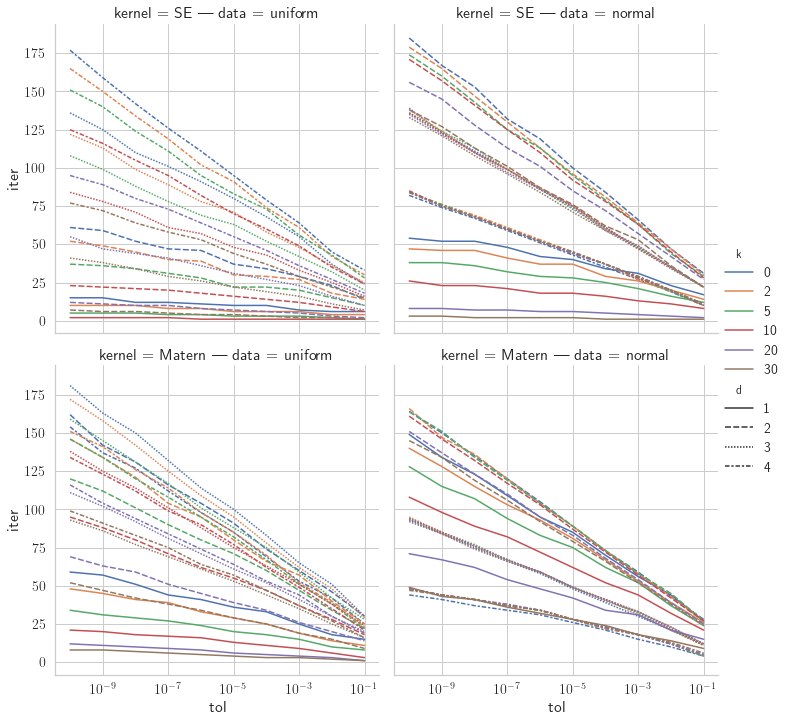

In [428]:
sns.relplot(x='tol', y='iter', col='data', row='kernel', hue='k', style='d', data=df, palette='deep', kind='line')
plt.xscale('log')

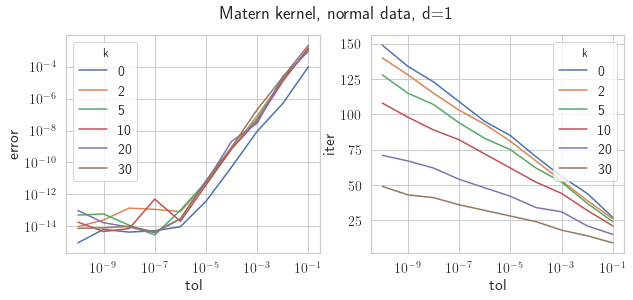

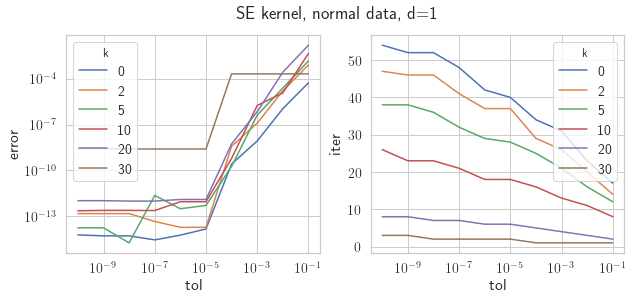

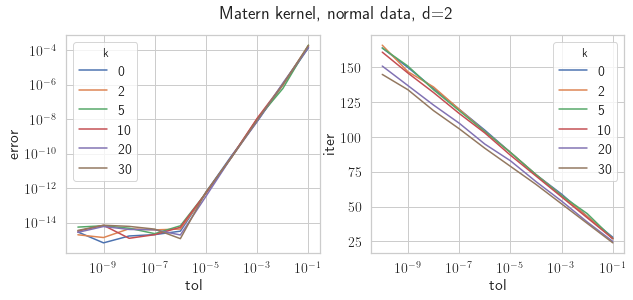

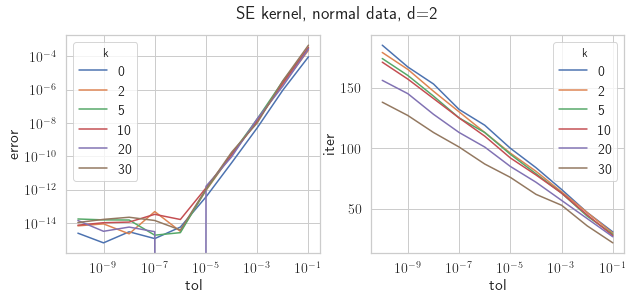

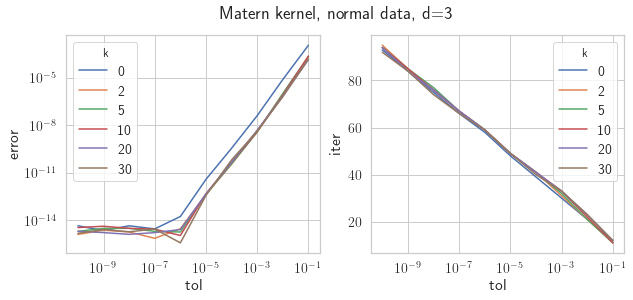

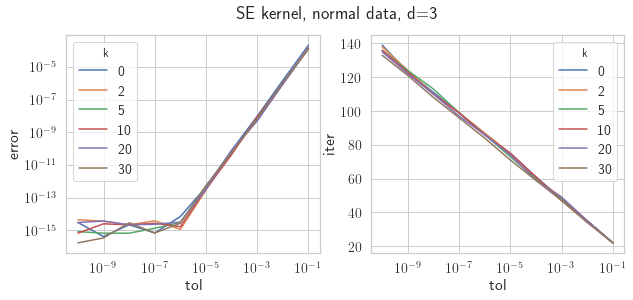

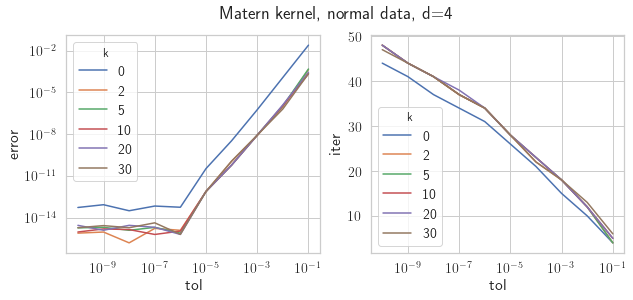

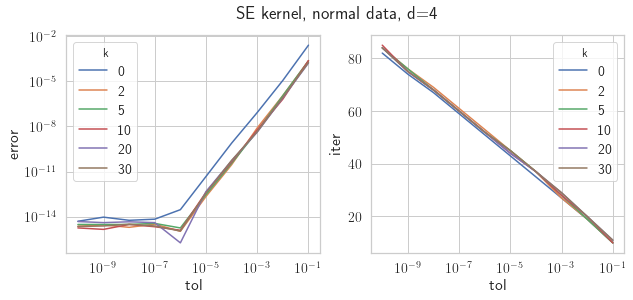

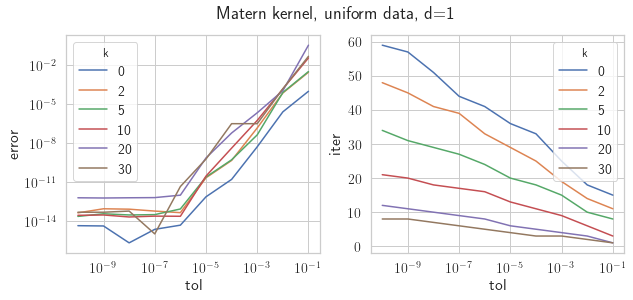

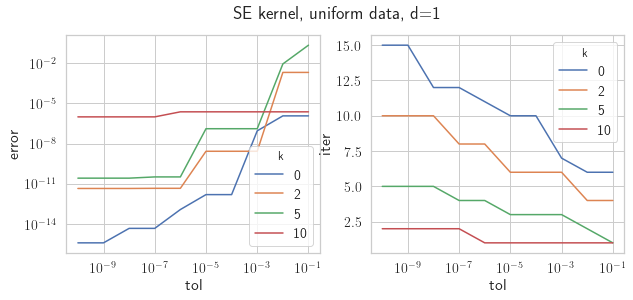

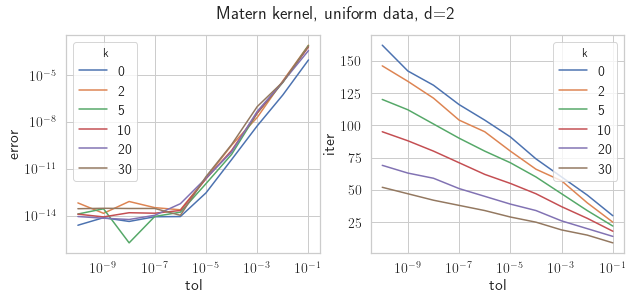

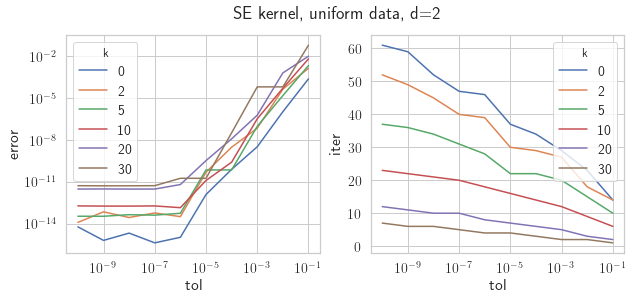

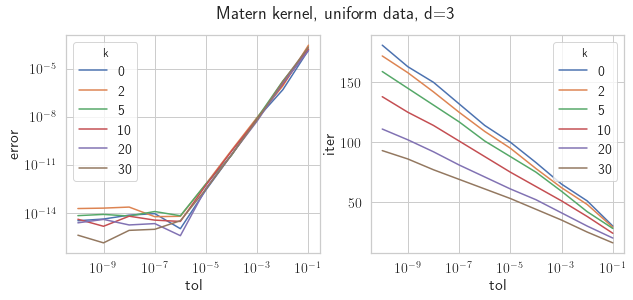

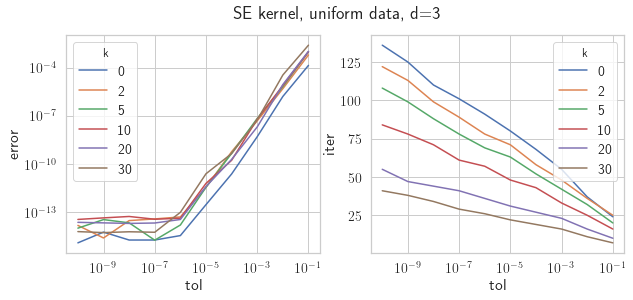

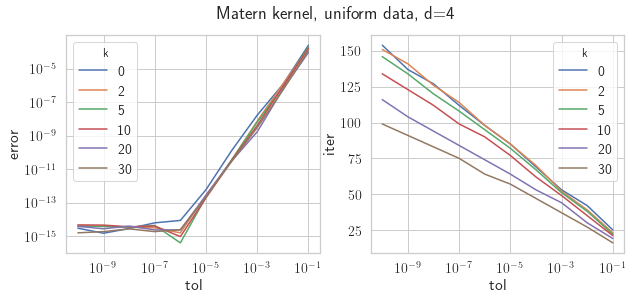

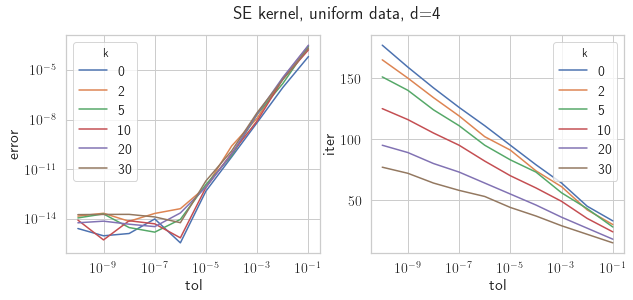

In [429]:
groups = ['data', 'd', 'kernel']
for group_values, subdf in df.groupby(groups):
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))

    filter_ = dict(zip(groups, group_values))
    mask = df[list(filter_.keys())].isin(list(filter_.values())).all(axis=1)
    subdf = df[mask]
    
    sns.lineplot(x='tol', y='error', data=subdf, hue='k', palette='deep', ax=ax[0])
    sns.lineplot(x='tol', y='iter', data=subdf, hue='k', palette='deep', ax=ax[1])

    ax[0].set_yscale('log')
    ax[0].set_xscale('log')
    ax[1].set_xscale('log')
    plt.suptitle(f'{filter_["kernel"]} kernel, {filter_["data"]} data, d={filter_["d"]}')

---

# Logdet computation

In [24]:
from src.inference import inference, compute_logdet

We study the convergence w.r.t. the number of probe vectors $N$. We are interested in the 95th quantile of the errors, so we must run several repetitions of the algorithm for each $N$ value. 

As an implementation note: since the code is in Python, it is very slow to call the inference engine many time. However, if we use many probe vectors, the computational overhead is essentially handled by low-level code. We just exploit that probe vectors are iid, so their corresponding logdet estimator are iid as well.

So if we want to call `inference` $r$ times with $N$ probe vectors, we rather call it once with $N\times r$ probe vectors, use the argument `return_avg=False`, and post-process the array. 

## Without preconditionning

We don't use kernel matrices here, as the condition number might get quite bad for big matrices, and the point is to show how stochastic lanczos quadrature works in general.

We show two experiments: a gentle and a "harder" case. This notion depends on the quantity

$$\frac{\Vert \log A \Vert_F^2}{\text{Tr}(A)^2} \; ,$$

which is always smaller than one for SPD matrices. The intuition is as follows: the frobenius norm is the variance of the trace estimator

$$\mathbf z^\top (\log A) \mathbf z \; .$$

Hence, if the trace is large compared to the frobenius norm (i.e., the above ratio is small), the variance will be small compared to the quantity of interest and only a few probe vectors are sufficient to obtain a good accuracy. On the other hand, if the frobenius norm is in the order of the trace, then many probe vectors are required to reach a good accuracy.


In [25]:
from math import floor

def postprocess_results(res, N):
    """
    Given a list of iid estimators, compute Monte Carlo estimates of N samples each.
    """
    quantiles = []
    res = np.array(res)
    np.random.shuffle(res)
    
    # Compute max number of replicas that we can make
    r = floor(res.shape[0] / N)
    # Discard extra samples
    res = res[:r*N]
    
    # Reshape as if we had r estimates and compute the mean
    res = res.reshape(r, N)
    res = res.mean(axis=1)
    return res

Let us start with the less gentle matrix:

In [26]:
n = 1000

# Build matrix
Q = torch.from_numpy(ortho_group.rvs(n))
eigs = torch.ones(n)
num = 10
eigs[0:num] = torch.linspace(10, 10*num, num)
A = Q @ torch.diag(eigs) @ Q.T

# Compute true logdet
truelogdet = eigs.log().sum().item()
truelogdet

38.13026350301597

In [27]:
relerr = 0.01
proba = 0.05
quantile = 1 - proba
info = dict()
Nbound, mbound = compute_logdet_bounds(eigs, relerr=relerr, proba_error=proba, info=info)
Nbound, mbound

(72466.66366251014, 50.84175617682864)

In [28]:
%%time
Ntot = int(5e4)
ms = (1, 2, 3, 4, 5, 10, 20, 50)
Ns = (1, 10, 100, 1000, 5000)

estimates = compute_logdet(A, Ntot, ms, return_avg=False)
res_q = dict()
for i, m in enumerate(ms):
    buffer = []
    for N in Ns:
        # Form Monte Carlo estimators with N samples each from the Ntot estimates
        res = postprocess_results(estimates[i, :], N)
        if i == 0:
            print(f'N={N} using {len(res)} Monte Carlo estimators')
        # Compute rel error and quantile
        relerrs = np.abs(res - truelogdet) / truelogdet
        q = np.quantile(relerrs, quantile)
        buffer.append(q)
        
    res_q[m] = buffer

N=1 using 50000 Monte Carlo estimators
N=10 using 5000 Monte Carlo estimators
N=100 using 500 Monte Carlo estimators
N=1000 using 50 Monte Carlo estimators
N=5000 using 10 Monte Carlo estimators
CPU times: user 1min 37s, sys: 19.4 s, total: 1min 57s
Wall time: 40.9 s


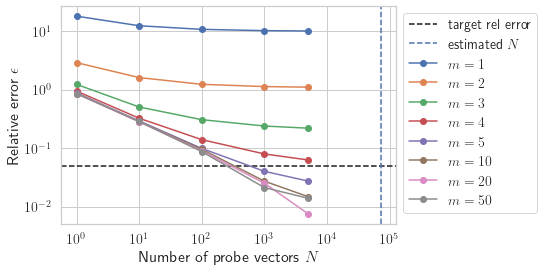

In [29]:
plt.axhline(1-quantile, ls='--', color='k', label='target rel error')
plt.axvline(Nbound, ls='--', label='estimated $N$')
for m, qs in res_q.items():
    plt.loglog(Ns, qs, '-o', label=f'$m={m}$')
    
plt.xlabel('Number of probe vectors $N$')
plt.ylabel('Relative error $\epsilon$')
plt.legend(bbox_to_anchor=(1,1));

Now the gentle matrix:

In [271]:
n = 1000

Q = torch.from_numpy(ortho_group.rvs(n))
eigs = torch.linspace(1, n, n)
A = Q @ torch.diag(eigs) @ Q.T

truelogdet = eigs.log().sum().item()
truelogdet

5912.128178488164

In [273]:
Nbound2, mbound2 = compute_logdet_bounds(eigs, relerr=relerr, proba_error=proba, info=info)
Nbound2, mbound2

(720.5861223854071, 131.58468193485206)

In [274]:
%%time
Ntot = int(5e4)
ms = (1, 2, 3, 4, 5, 10, 20, 50)
Ns = (1, 10, 100, 1000, 5000)

estimates = compute_logdet(A, Ntot, ms, return_avg=False)
res_q2 = dict()
for i, m in enumerate(ms):
    buffer = []
    for N in Ns:
        # Form Monte Carlo estimators with N samples each from the Ntot estimates
        res = postprocess_results(estimates[i, :], N)
        if i == 0:
            print(f'N={N} using {len(res)} Monte Carlo estimators')
        # Compute rel error and quantile
        relerrs = np.abs(res - truelogdet) / truelogdet
        q = np.quantile(relerrs, quantile)
        buffer.append(q)
        
    res_q2[m] = buffer

N=1 using 50000 Monte Carlo estimators
N=10 using 5000 Monte Carlo estimators
N=100 using 500 Monte Carlo estimators
N=1000 using 50 Monte Carlo estimators
N=5000 using 10 Monte Carlo estimators
CPU times: user 4min 19s, sys: 50 s, total: 5min 9s
Wall time: 1min 19s


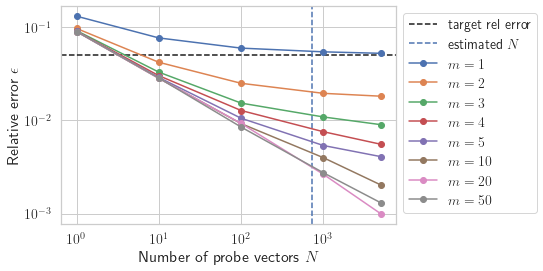

In [275]:
plt.axhline(1-quantile, ls='--', color='k', label='target rel error')
plt.axvline(Nbound2, ls='--', label='estimated $N$')
for m, qs in res_q2.items():
    plt.loglog(Ns, qs, '-o', label=f'$m={m}$')
    
plt.xlabel('Number of probe vectors $N$')
plt.ylabel('Relative error $\epsilon$')
plt.legend(bbox_to_anchor=(1,1));

And make a nice figure for the report:

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


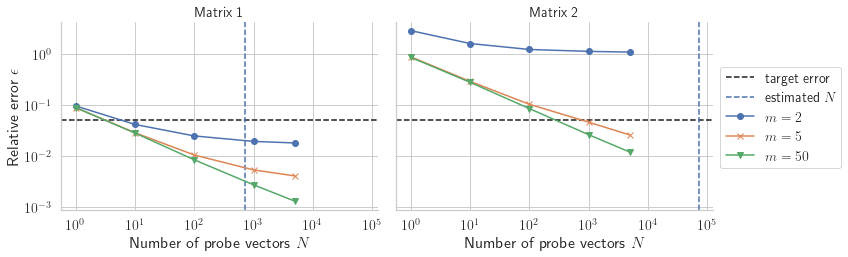

In [277]:
_, ax = plt.subplots(1, 2, figsize=(12, 3.8), sharex=True, sharey=True)
Nbounds = (Nbound2, Nbound)
plot_ms = (2, 5, 50)
markers = ('o', 'x', 'v')

for i, q in enumerate((res_q2, res_q)):
    ax[i].axhline(1-quantile, ls='--', color='k', label='target error')
    ax[i].axvline(Nbounds[i], ls='--', label='estimated $N$')
    for m, marker in zip(plot_ms, markers):
        qs = q[m]
        ax[i].loglog(Ns, qs, label=f'$m={m}$', marker=marker)

    ax[i].set_title(f'Matrix {i+1}')
    ax[i].set_xlabel('Number of probe vectors $N$')
    
ax[0].set_ylabel('Relative error $\epsilon$')
ax[1].legend(bbox_to_anchor=(1,.8));
    
plt.tight_layout();
process_figure('logdet_mbcg')

## With preconditionning

In [182]:
from src.inference import inference
from src.model import GPModel
import pandas as pd

In [221]:
n, d = 100, 1

ks = (1, 3, 5, 7, 9)
Ns = (1, 10, 100)
reps = (100, 100, 100)
mbcg_tol = 1e-10

y = torch.randn(n)
xs = [
    torch.linspace(0, 1, n),
    torch.randn(n, 1),
    #torch.randn(n, 2)
]
xs_desc = ['uniform grid', 'std normal 1D', 'std normal 2D']

sigma2, lengthscale = 0.1, 0.1

kernels = [
    # | --- class object ---| |-- name -|  |-- parameters ----|
    (SquaredExponentialKernel, 'SE',     {'lengthscale': 0.25}),
    #(MaternKernel,             'Matern', {'lengthscale': 0.25, 'nu': 2.5}),
]

data = []
for kernel, desc, params in kernels:
    for x, x_desc in zip(xs, xs_desc):
        print(f'kernel={desc}, data={x_desc}')
        K = kernel(x)
        K.compute_kernel_and_grad(torch.tensor([sigma2, *params.values()]))

        logdet_true = torch.logdet(K.Khat())
        M_trace = torch.linalg.inv(K.Khat()) @ K.grad
        traces_true = torch.tensor([torch.trace(M) for M in M_trace])
        Kinvy_true = torch.linalg.solve(K.Khat(), y)

        model = GPModel(x, y, K, torch.tensor([sigma2, lengthscale]))

        for k in ks:
            for N, r in zip(Ns, reps):
                err_logdet = []
                err_traces = []
                n_iters = []
                for _ in range(r):
                    Kinvy, logdet, traces = inference(y, K, k=k, N=N, m=100, info=info, mbcg_tol=mbcg_tol)

                    err_logdet.append(abs(logdet.item() - logdet_true) / abs(logdet_true))
                    err_traces.append(torch.abs((traces - traces_true) / traces_true))
                    err_Kinvy = torch.norm(Kinvy - Kinvy_true) / torch.norm(Kinvy_true)
                    n_iters.append(info['niter'])

                err_logdet = np.mean(err_logdet)
                err_traces = torch.stack(err_traces).mean(dim=0)
                n_iters = np.mean(n_iters)
                #print(f'k={k}, N={N}, r={r}, niter={n_iters:.3}', end=', ')

                data.append({
                    'kernel': desc,
                    'k': k,
                    'N': N,
                    'reps': r,
                    'x_desc': x_desc,
                    'mean_iter': n_iters,
                    'logdet': err_logdet,
                    'traces': err_traces
                })

kernel=SE, data=uniform grid
kernel=SE, data=std normal 1D


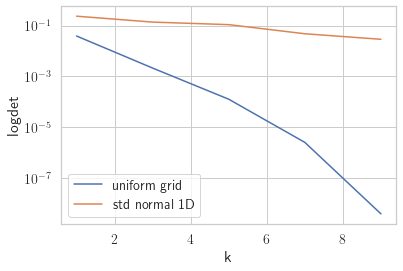

In [235]:
df = pd.DataFrame(data)
sns.lineplot(x='k', y='logdet', hue='x_desc', data=df[df.N==100], palette='deep')
plt.yscale('log')
plt.legend(title='')

In [200]:
n = 100
y = torch.randn(n)
x = torch.linspace(0, 1, n)
#x = torch.randn(n)

sigma2, lengthscale = 0.1, 1.0

K = SquaredExponentialKernel(x)
K.compute_kernel_and_grad(torch.tensor([sigma2, lengthscale]))

logdet_true = torch.logdet(K.Khat())
M_trace = torch.linalg.inv(K.Khat()) @ K.grad
traces_true = torch.tensor([torch.trace(M) for M in M_trace])

Kinvy_true = torch.linalg.solve(K.Khat(), y)

In [201]:

info = dict()

ks = (0, 1, 3, 5, 7, 9)
Ns = (1, 10, 100)
reps = (100, 100, 100)

errs_logdet, errs_traces, errs_Kinvy = dict(), dict(), dict()
for k in ks:
    for N, r in zip(Ns, reps):
        err_logdet = []
        err_traces = []
        for _ in range(r):
            Kinvy, logdet, traces = inference(y, K, k=k, N=N, m=100, info=info)

            err_logdet.append(abs(logdet.item() - logdet_true) / abs(logdet_true))
            err_traces.append(torch.abs((traces - traces_true) / traces_true))
            err_Kinvy = torch.norm(Kinvy - Kinvy_true) / torch.norm(Kinvy_true)

        print(f'N={N}, r={r}, info={info}', end=', ')
        err_logdet = np.mean(err_logdet)
        err_traces = torch.stack(err_traces).mean(dim=0)

        errs_logdet[(k, N)] = err_logdet
        errs_traces[(k, N)] = err_traces
        errs_Kinvy[(k, N)] = err_Kinvy
        
        #errs_logdet.append(err_logdet)
        #errs_traces.append(err_traces)
        #errs_Kinvy.append(err_Kinvy)

N=1, r=100, info={'niter': 9}, N=10, r=100, info={'niter': 9}, N=100, r=100, info={'niter': 9}, N=1, r=100, info={'niter': 7}, N=10, r=100, info={'niter': 7}, N=100, r=100, info={'niter': 7}, N=1, r=100, info={'niter': 4}, N=10, r=100, info={'niter': 4}, N=100, r=100, info={'niter': 4}, N=1, r=100, info={'niter': 3}, N=10, r=100, info={'niter': 3}, N=100, r=100, info={'niter': 3}, N=1, r=100, info={'niter': 2}, N=10, r=100, info={'niter': 2}, N=100, r=100, info={'niter': 2}, N=1, r=100, info={'niter': 1}, N=10, r=100, info={'niter': 1}, N=100, r=100, info={'niter': 1}, 

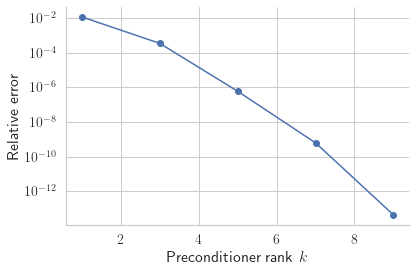

In [202]:
data_plot = [
    errs_logdet[(k, 100)] for k in ks if k > 0
]
plt.semilogy(ks[1:], data_plot, '-o')
plt.xlabel('Preconditioner rank $k$')
plt.ylabel('Relative error')
process_figure('logdet_precond_errvsk')

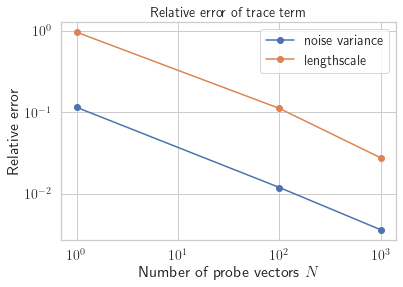

In [186]:
data = []
for N in Ns:
    data_plot = [
        errs_traces[(k, N)] for k in ks if k > 0
    ]
    data_plot = torch.stack(data_plot).mean(dim=0)
    data.append(data_plot)
    
data = torch.stack(data)
plt.loglog(Ns, data[:, 0], '-o', label='noise variance')
plt.loglog(Ns, data[:, 1], '-o', label='lengthscale')
plt.legend();
plt.xlabel('Number of probe vectors $N$')
plt.ylabel('Relative error')
plt.title('Relative error of trace term');

# Likelihood computation

In [6]:
from src.model import GPModel

In [7]:
from scipy.stats import multivariate_normal

def true_likelihood(y, cov):
    if y.ndim == 2 and y.shape[1] == 1:
        y = y.ravel()
    elif y.ndim != 1:
        raise ValueError
        
    pdf = multivariate_normal.pdf(y, mean=np.zeros_like(y), cov=cov)
    likelihood = np.log(pdf)
    return likelihood

In [8]:
from time import perf_counter
import pandas as pd

In [9]:
from src.kernel import Kernel

def compute_true_likelihood_grad(k: Kernel, y):
    grad = []
    ysolve = torch.linalg.solve(k.Khat(), y)
    for grad_i in k.grad:
        term1 = 0.5 * ysolve.T @ grad_i @ ysolve
        term2 = -0.5 * torch.linalg.solve(k.Khat(), grad_i).trace()
        grad.append(term1 + term2)
    
    return torch.tensor(grad)

In [41]:
sigma2 = 0.1

kernels = [
    # | --- class object ---| |-- name -|  |-- parameters ----|
    (SquaredExponentialKernel, 'SE',     {'lengthscale': 0.25}),
    (MaternKernel,             'Matern', {'lengthscale': 0.25, 'nu': 2.5}),
]

data = []

n, d = 1000, 1
reps = 20
x = torch.randn(n, 1)
#x = torch.rand(n, 2)
y = (2*torch.pi*x).sin() + torch.randn(n, 1) * sigma2**0.5
#y = (2*torch.pi*x[:, 0]).sin() - x[:, 1]**2
#ks = (0, 2, 5, 8, 11, 14)
ks = (0, 5, 10, 15, 20, 25, 30)
Ns = (10, 100, 1000)

for kernel, desc, params in kernels:
    hyperparams = torch.tensor([sigma2, *params.values()])
    K = kernel(x)
    model = GPModel(x, y, K, hyperparams)
    K.compute_kernel_and_grad(hyperparams)
    L_true = true_likelihood(y, K.Khat())
    dL_true = compute_true_likelihood_grad(K, y)
    
    for N in Ns:
        print(f'{desc}, N={N}', end='; ')
        for k in ks:
            err_L, err_dL = [], []
            time = []
            niter = []
            for _ in range(reps):
                info = dict()
                start = perf_counter()
                L, dL, ysolve = model.compute_likelihood(k=k, N=N, m=150, info=info)

                time.append(perf_counter() - start)

                err_L.append(abs((L - L_true) / L_true))
                err_dL.append( ( (dL - dL_true) / dL_true ).abs() )
                niter.append(info['niter'])

            err_L = torch.tensor(err_L).mean().item()
            err_dL = torch.stack(err_dL).mean(dim=0)
            time = np.mean(time)
            niter = np.mean(niter)
            data.append({
                'kernel': desc,
                'kernel_params': params,
                'k': k,
                'err_L': err_L,
                'err_dL': err_dL,
                'time': time,
                'niter': niter,
                'N': N
            })

SE, N=10; SE, N=100; SE, N=1000; Matern, N=10; Matern, N=100; Matern, N=1000; 

In [42]:
df = pd.DataFrame(data)
df['err_dL_noise'] = df.err_dL.apply(lambda e: e[0].item())
df['err_dL_l'] = df.err_dL.apply(lambda e: e[1].item())
df#.head()

,kernel,kernel_params,k,err_L,err_dL,time,niter,N,err_dL_noise,err_dL_l
0,SE,{'lengthscale': 0.25},0,1.269675e-01,"[tensor(0.5418), tensor(0.0665)]",0.087370,67.85,10,0.541843,0.066547
1,SE,{'lengthscale': 0.25},5,3.414750e-02,"[tensor(0.5354), tensor(0.1862)]",0.195008,45.10,10,0.535441,0.186243
2,SE,{'lengthscale': 0.25},10,8.227420e-03,"[tensor(0.4775), tensor(0.0979)]",0.339640,29.40,10,0.477473,0.097945
3,SE,{'lengthscale': 0.25},15,4.166303e-03,"[tensor(0.3487), tensor(0.0921)]",0.504413,16.95,10,0.348739,0.092100
4,SE,{'lengthscale': 0.25},20,1.688435e-03,"[tensor(0.5933), tensor(0.0723)]",0.641335,9.00,10,0.593342,0.072331
5,SE,{'lengthscale': 0.25},25,1.847532e-04,"[tensor(0.4054), tensor(0.0851)]",0.918268,5.85,10,0.405394,0.085059
6,SE,{'lengthscale': 0.25},30,3.221714e-06,"[tensor(0.5740), tensor(0.0722)]",1.016005,4.00,10,0.574030,0.072174
7,SE,{'lengthscale': 0.25},0,1.337641e-01,"[tensor(0.1720), tensor(0.0243)]",1.298415,67.10,100,0.172048,0.024349
8,SE,{'lengthscale': 0.25},5,3.901305e-02,"[tensor(0.1354), tensor(0.0565)]",0.674193,46.40,100,0.135410,0.056508
9,SE,{'lengthscale': 0.25},10,4.316798e-03,"[tensor(0.1568), tensor(0.0438)]",0.439429,30.00,100,0.156822,0.043753


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


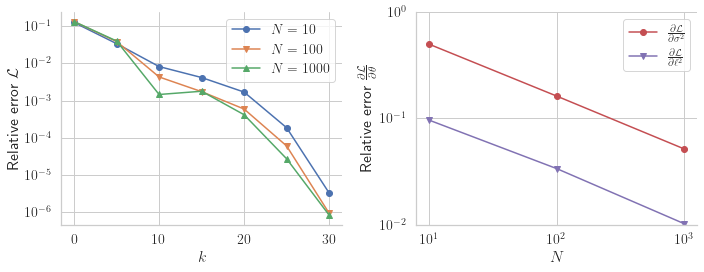

In [74]:
df_plot = df[df.kernel=='SE']
_, ax = plt.subplots(1, 2, figsize=(10, 4))

Ns = df_plot.N.unique()
colors = sns.color_palette('deep', n_colors=len(Ns) + 2)
markers = ['o', 'v', '^']

# Convergence of likelihood
for N, col, m in zip(Ns, colors, markers):
    sub = df_plot[df_plot.N == N]
    ax[0].semilogy(sub.k, sub.err_L, label=f'$N={N}$', marker=m, color=col)
    
ax[0].legend()
ax[0].set_xlabel('$k$')
ax[0].set_ylabel('Relative error $\mathcal L$')

#for N, col in zip(Ns, colors):
#    sub = df_plot[df_plot.N == N]
#    ax[1].plot(sub.k, sub.niter)

# Convergence of gradient
sub = df_plot.groupby('N').mean()
ax[1].loglog(sub.index, sub.err_dL_noise, label=r'$\frac{\partial \mathcal L}{\partial \sigma^2}$', marker='o', color=colors[-2])
ax[1].loglog(sub.index, sub.err_dL_l, label=r'$\frac{\partial \mathcal L}{\partial \ell^2}$', marker='v', color=colors[-1])
ax[1].set_xlabel('$N$')
ax[1].set_ylabel(r'Relative error $\frac{\partial \mathcal L}{\partial \theta}$')
ax[1].legend()
ax[1].set_ylim([1e-2, 1e0])
    
#plt.tight_layout()
process_figure('likelihood')

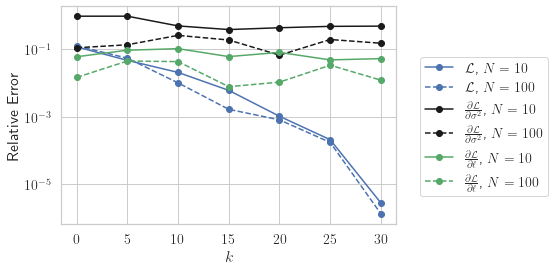

In [40]:
df_plot = df[df.kernel=='SE']

Ns = [10, 100]
lss = ['-', '--']

for N, ls in zip(Ns, lss):
    sub = df_plot[df_plot.N == N]
    plt.semilogy(sub.k, sub.err_L, label=f'$\mathcal L$, $N={N}$', marker='o', ls=ls, color='b')

for N, ls in zip(Ns, lss):
    sub = df_plot[df_plot.N == N]
    plt.semilogy(sub.k, sub.err_dL_noise, label=r'$\frac{\partial \mathcal L}{\partial \sigma^2}$,'+ f' $N={N}$', marker='o', ls=ls, color='k')

for N, ls in zip(Ns, lss):
    sub = df_plot[df_plot.N == N]
    plt.semilogy(sub.k, sub.err_dL_l, label=r'$\frac{\partial \mathcal L}{\partial \ell}$,'+ f' $N={N}$', marker='o', ls=ls, color='g')
    
plt.legend(bbox_to_anchor=(1.05, 0.8));
plt.ylabel('Relative Error')
plt.xlabel('$k$');

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


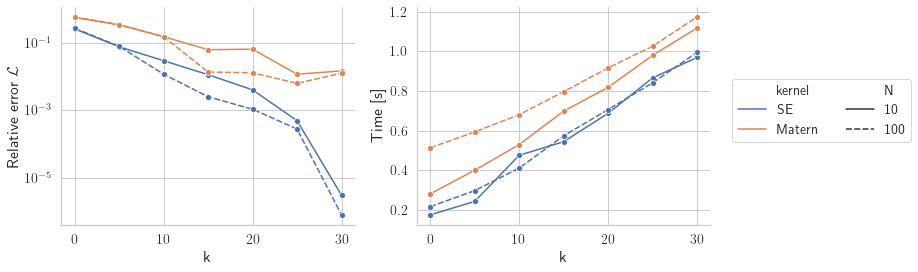

In [33]:
_, ax = plt.subplots(1, 2, figsize=(13, 4), sharex=True)

sns.lineplot(data=df, x='k', y='err_L', hue='kernel', style='N', marker='o', ax=ax[0])
ax[0].set_ylabel('Relative error $\mathcal L$')
ax[0].semilogy();
#ax[0].set_ylim(1e-10, 1)
ax[0].legend_.remove()

sns.lineplot(data=df, x='k', y='time', hue='kernel', style='N', marker='o', ax=ax[1])
ax[1].set_ylabel('Time [s]')
ax[1].legend(bbox_to_anchor=(1.05, 0.7), ncol=2)

process_figure('likelihood_1d_stdnormal')

In [31]:
!nautilus .

In [49]:
n, d = 100, 1
x = torch.rand(n, d)
y = x.sin()

sigma2 = 0.1
lengthscale = 0.25
hyperparams = torch.tensor([sigma2, lengthscale])

kernel = SquaredExponentialKernel(x)
model = GPModel(x, y, kernel, hyperparams)

logdet = None
def callback(*args):
    global logdet
    logdet = args[1]
L, dL, ysolve = model.compute_likelihood(k=10, N=100, m=20, callback_inference=callback)

L_true = true_likelihood(y, kernel.Khat())
ysolve_true = torch.linalg.solve(kernel.Khat(), y).ravel()



In [53]:
L_true, L, (L-L_true)

(13.0177510831221, tensor([13.0178]), tensor([7.7472e-08]))

In [47]:
Khat = kernel.Khat()
torch.logdet(Khat), logdet

(tensor(-179.8912), -179.3614098154401)

In [15]:
logdet

-45.03374773395484

In [8]:
true_likelihood(y, kernel.Khat())

-70.57661765595978

# Regression example

In [33]:
from src.model import GPModel

In [59]:
%%time
n, d = 50, 1
sigma2 = 0.1
x = torch.rand(n, d)
f = lambda x: (2*torch.pi*x).sin()
y = f(x) + torch.randn(n, 1) * sigma2**0.5

lengthscale = 0.5
hyperparams = torch.tensor([0.01, lengthscale])

kernel = SquaredExponentialKernel(x)
model = GPModel(x, y, kernel, hyperparams)
pred_mean, pred_cov, l = model.train()

CPU times: user 3 s, sys: 4.41 ms, total: 3.01 s
Wall time: 723 ms


In [60]:
kernel.sigma2, kernel.lengthscale

(0.10128219741818326, 0.165808290439657)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


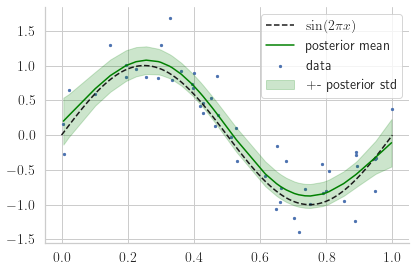

In [65]:
x = x.squeeze(-1)
y = y.squeeze(-1)
sid = torch.argsort(x, dim=0)
plt.scatter(x[sid], y[sid], s=5, label='data')
grid = torch.linspace(0, 1, 100)
plt.plot(grid, f(grid), '--k', label='$\sin(2\pi x)$')
plt.plot(x[sid], pred_mean[sid], label='posterior mean', color='green')
pred_std = 2*pred_cov ** 0.5
plt.fill_between(x[sid], pred_mean[sid] - pred_std[sid], pred_mean[sid] + pred_std[sid],
                 label='+- posterior std', color='green', alpha=.2)
plt.legend()
process_figure('toy_example')

In [66]:
pwd


'/media/maousi/FastData/Programming/DS-MA4/GP-linalg/tutorial'

# Timing benchmark

In [14]:
from src.precond import PartialCholesky
from src.inference import inference

In [16]:
n = 5_000
d = 10
l = 1.0
sigma2 = 0.05

x = torch.randn(n, d)
K = SquaredExponentialKernel(x).compute_kernel(l)

In [12]:
%%timeit
torch.logdet(K)

433 ms ± 15.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
%%timeit
inference(K, k=15, sigma2=sigma2, N=1, m=3)

2.57 s ± 30.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [21]:
%%timeit
P = PartialCholesky(K, max_rank=15, sigma2=sigma2)

2.45 s ± 19.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [27]:
import tensorflow as tf
import tensorflow_probability as tfp

In [34]:
%%timeit
tfp.math.pivoted_cholesky(tf.convert_to_tensor(K), max_rank=15, diag_rtol=1e-10)

96.9 ms ± 668 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Logdet

# Error Lanczos quadrature

The error upperbound is (see Cortinovis paper):
$$
|\mathbf x^\top \log(A) \mathbf x - \Vert \mathbf x \Vert_2^2 \mathbf e_1^\top log(T_m) \mathbf e_1 |
\le c_a \Vert \mathbf x \Vert_2^2 \left( \frac{\sqrt{\kappa(A) + 1} - 1}{\sqrt{\kappa(A) + 1} + 1} \right) ^{2m},
\quad c_A := 2 ( \sqrt{\kappa(A) + 1} + 1) \log(2\kappa(A))
$$

Aim: for a SPD matrix $A$ with known eigenvalues, compute some big number of Lanczos steps $M$ and visualize the error for different numbers $m$. The $T_m$ matrix can be extracted from the big $T_M$ matrix. 

In [317]:
from src.quadrature import lanczos_quadrature
from src.cg import mbcg
from src.chol import pivoted_chol

First generate the matrix $A = Q \Lambda Q^\top$ with eigenvalues evenly distributed logarithmically in $[1, 10^4]$

In [352]:
n = 500
sigma2 = 1.0
eigs = torch.logspace(0, 4, n)
#eigs = torch.linspace(1, 1e4, n)
Q = torch.from_numpy(ortho_group.rvs(n))
A = Q @ torch.diag(eigs) @ Q.T

Run the mBCG algorithm with $M = n$ steps:

In [353]:
M = 500
# Probe vector
x = torch.randn(n)
x0 = torch.zeros(n)

sol, (T,) = mbcg(lambda X: A@X, lambda X: X, x, x0, M)
trueval = (x.T @ Q) @ torch.diag(eigs.log()) @ (Q.T @ x)

Compute the $m$-step Lanczos quadratures from the matrix $T \in \mathbb R^{M \times M}$, with $T_m = T_{1:m, 1:m}$

In [354]:
ms = np.linspace(10, M, 10, dtype=int)
quadrature_estimates = [
    lanczos_quadrature(f=torch.log, Tm=T[:m, :m], z=x, matrix_size=n)
    for m in ms
]

Compute the convergence rate:

In [355]:
def compute_convergence_rate(eigs):
    condA = eigs.max() / eigs.min()
    factor_cond = (condA + 1) ** 0.5
    #cA = 2 * (factor_cond + 1) * np.log(2*condA)
    convergence_rate = (factor_cond - 1) / (factor_cond + 1)
    return convergence_rate**2
    #return x.dot(x) * cA * convergence_rate**(2*ms)

In [356]:
convergence_rate = compute_convergence_rate(eigs)
convergence_rate

tensor(0.9608)

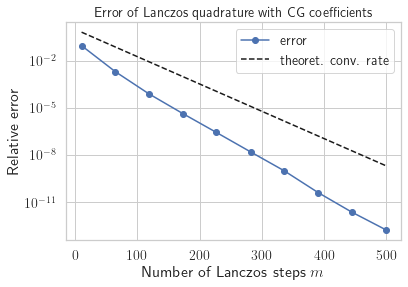

In [357]:
errs = (trueval - torch.tensor(quadrature_estimates)).abs() / trueval
#bound = compute_quadrature_upperbound(eigs, ms, x)
plt.semilogy(ms, errs, '-o', label='error')
plt.semilogy(ms, convergence_rate**ms, '--k', label='theoret. conv. rate')
plt.xlabel('Number of Lanczos steps $m$')
plt.ylabel('Relative error')
plt.title('Error of Lanczos quadrature with CG coefficients')
plt.legend();

Question: why works better if linspace eigvals? => if logspace, more clustered, Lanczos works best with well separated eigvals?

# Bounds on $N$, $m$

In [5]:
from math import log10

def build_A(n: int, lmin: float, lmax: float, device='cuda'):
    assert lmin > 0
    
    Q = torch.from_numpy(ortho_group.rvs(n)).to(device)
    eigs = torch.logspace(log10(lmin), log10(lmax), n, device=device)
    A = Q @ torch.diag(eigs) @ Q.T
    
    return A, eigs

In [6]:
A, eigs = build_A(1000, 1, 10000)

In [19]:
# True logdet
eigs.log().sum(), torch.logdet(A)

(tensor(4605.1702, device='cuda:0'), tensor(4605.1702, device='cuda:0'))

In [7]:
relerr = 0.05
proba_error = 0.5

Nmin, m_min = compute_logdet_bounds(eigs, relerr, proba_error)
Nmin, m_min

(17.753737976206686, 416.78731981107336)

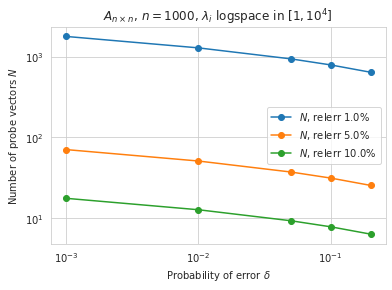

In [33]:
relerrs = (0.01, 0.05, 0.1)
probas = (0.001, 0.01, 0.05, 0.1, 0.2)


for relerr in relerrs:
    bounds = [
        compute_logdet_bounds(eigs, relerr, proba)
        for proba in probas
    ]
    Ns, ms = zip(*bounds)
    plt.plot(probas, Ns, '-o', label=f'$N$, relerr {relerr*100}%')

plt.legend()
plt.yscale('log'); plt.xscale('log')
plt.tick_params(axis='y', which='minor')
plt.xlabel('Probability of error $\delta$')
plt.ylabel('Number of probe vectors $N$')
plt.title(r'$A_{n \times n}, \, n = 1000$, $\lambda_i$ logspace in $[1, 10^4]$');

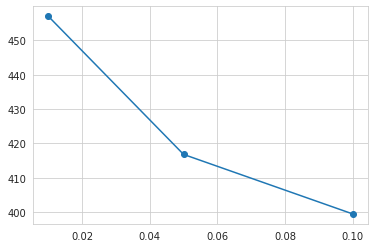

In [68]:
ms = [
    compute_logdet_bounds(eigs, relerr, 0.1)[1]
    for relerr in relerrs
]
plt.plot(relerrs, ms, '-o')

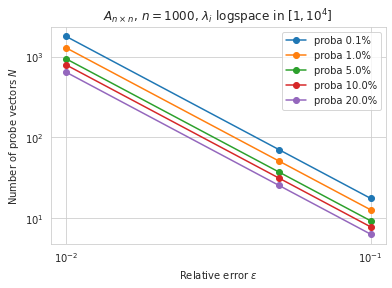

In [25]:
relerrs = (0.01, 0.05, 0.1)
probas = (0.001, 0.01, 0.05, 0.1, 0.2)

for proba in probas:
    bounds = [
        compute_logdet_bounds(eigs, relerr, proba)
        for relerr in relerrs
    ]
    Ns, ms = zip(*bounds)
    plt.plot(relerrs, Ns, '-o', label=f'proba {proba*100}%')

#plt.xscale('log')
plt.legend()
plt.yscale('log'); plt.xscale('log')
plt.tick_params(axis='y', which='minor')
plt.xlabel('Relative error $\epsilon$')
plt.ylabel('Number of probe vectors $N$')
plt.title(r'$A_{n \times n}, \, n = 1000$, $\lambda_i$ logspace in $[1, 10^4]$');

# Logdet of SPD matrix

In [27]:
from src.inference import compute_logdet

## Logdet without preconditionning

We don't use preconditionning here, so the matrix has to be well-conditionned, otherwise the number of Lanczos steps will be too big.

In [52]:
from math import log10

def build_A(n: int, lmin: float, lmax: float, logspace: bool = True, device='cuda'):
    assert lmin > 0
    
    Q = torch.from_numpy(ortho_group.rvs(n)).to(device)
    if logspace:
        eigs = torch.logspace(log10(lmin), log10(lmax), n, device=device)
    else:
        eigs = torch.linspace(lmin, lmax, n, device=device)
    A = Q @ torch.diag(eigs) @ Q.T
    
    return A, eigs

In [82]:
A, eigs = build_A(n=1000, lmin=1, lmax=1e2, logspace=True, device='cpu')

compute_logdet_bounds(eigs, 0.05, 0.05)

(37.41322728914573, 36.49501263710895)

In [84]:
%%time
Ns = (10, 37, 50, 100)
m = 37
reps = 1000

results = []
for N in Ns:
    # The estimates are iid, so compute everything in one shot
    estimates = compute_logdet(A, N*reps, m, return_avg=False)
    # Compute the averages for each independent run
    estimates = estimates.reshape(reps, N).mean(axis=1)
    results.append(estimates)

CPU times: user 11min 48s, sys: 2min 24s, total: 14min 13s
Wall time: 2min 57s


In [101]:
true = eigs.log().sum().item()
rel_errors_perc = np.abs(np.array(results) - true) / true * 100
rel_errors_perc

array([[1.37285149, 1.06600406, 0.58785305, ..., 1.57906322, 1.44397915,
        2.71377201],
       [0.53399371, 0.57004062, 1.62728347, ..., 0.61725416, 0.83215492,
        0.1599653 ],
       [0.41959915, 0.45693282, 0.79778446, ..., 0.0362663 , 0.36864048,
        0.09671768],
       [0.59246946, 0.87126263, 0.2813759 , ..., 1.01137869, 0.13781759,
        0.16449207]])

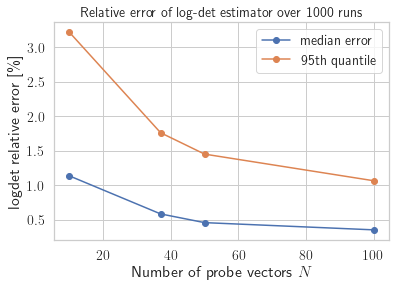

In [119]:
# Mean errors
plt.plot(Ns, np.median(rel_errors_perc, axis=1), '-o', label='median error')
# 95th Quantile
q = np.quantile(rel_errors_perc, 0.95, axis=1)

plt.title(f'Relative error of log-det estimator over {reps} runs')
plt.plot(Ns, q, '-o', label='95th quantile')
plt.ylabel('logdet relative error [\%]')
plt.xlabel('Number of probe vectors $N$')
plt.legend();

# Check mbcg

In [62]:
# Conjugate gradients from scipy library
from scipy.sparse.linalg import cg as sp_cg

In [63]:
def callback(error_lst, xtrue):
    """
    Helper callback function: iterative methods (e.g, CG) can be provided a callback function,
    i.e. a function that will be called at each step of the iterative method with the input
    being the current solution. 
    This helper function provides a concise way of measuring the error at each step.
    
    :param error_lst: the list in which errors will be stored at each step
    :param xtrue: the true solution used to compute the error
    """
    xtrue_norm = (xtrue ** 2).sum()
    def inner(xk):
        """Wrapped function. `inner` will be called by the iterative methhod."""
        error_stepk = xk - xtrue
        # Compute l2-norm
        error_stepk = (error_stepk ** 2).sum() ** 0.5 / xtrue_norm
        error_lst.append(error_stepk)
        
    return inner

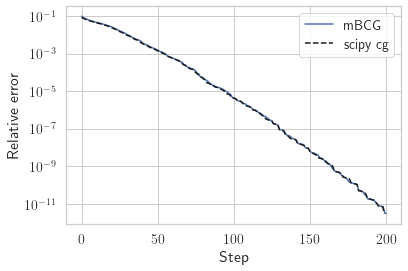

In [64]:
# === Generate the matrix A from its eigendecomposition
# Size of the matrix
n = 100
# Generate random orthogonal matrix
Q = torch.from_numpy(ortho_group.rvs(n))
# Generate eigenvalues
eigs = torch.logspace(0, 3, n)
#eigs = torch.linspace(1, 1e3, n)
# Compute A explicitly
A = Q @ torch.diag(eigs) @ Q.T

# === Generate solution and then the RHS of equation Ax = b
x = torch.randn(n)
b = A @ x

# === Approximation with iterative methods
# Starting solution for iterative methods
x0 = torch.zeros(n)
# Number of steps
k = 2*n

# mBCG algorithm
errors_mbcg = []
xk, _ = mbcg(lambda X: A@X, lambda X: X, b, torch.zeros_like(b), k, callback=callback(errors_mbcg, x))

# scipy reference algorithm
errors_sp = []
sp_cg(A.numpy(), b.numpy(), x0.numpy(), tol=1e-16, maxiter=k, callback=callback(errors_sp, x.numpy()));

# === Plot the errors
plt.semilogy(errors_mbcg, label='mBCG')
plt.semilogy(errors_sp, '--k', label='scipy cg')
plt.legend()
plt.xlabel('Step'); plt.ylabel('Relative error');

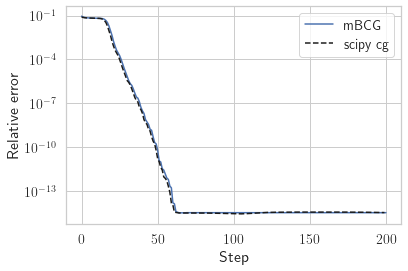

In [73]:
# === Generate the matrix A from its eigendecomposition
# Size of the matrix
n = 100
# Generate random orthogonal matrix
Q = torch.from_numpy(ortho_group.rvs(n))
# Generate eigenvalues
eigs = torch.logspace(0, 3, n)
eigs[:50] = 1.0
#eigs = torch.linspace(1, 1e3, n)
# Compute A explicitly
A = Q @ torch.diag(eigs) @ Q.T

# === Generate solution and then the RHS of equation Ax = b
x = torch.randn(n)
b = A @ x

# === Approximation with iterative methods
# Starting solution for iterative methods
x0 = torch.zeros(n)
# Number of steps
k = 2*n

# mBCG algorithm
errors_mbcg = []
xk, _ = mbcg(lambda X: A@X, lambda X: X, b, torch.zeros_like(b), k, callback=callback(errors_mbcg, x))

# scipy reference algorithm
errors_sp = []
sp_cg(A.numpy(), b.numpy(), x0.numpy(), tol=1e-16, maxiter=k, callback=callback(errors_sp, x.numpy()));

# === Plot the errors
plt.semilogy(errors_mbcg, label='mBCG')
plt.semilogy(errors_sp, '--k', label='scipy cg')
plt.legend()
plt.xlabel('Step'); plt.ylabel('Relative error');

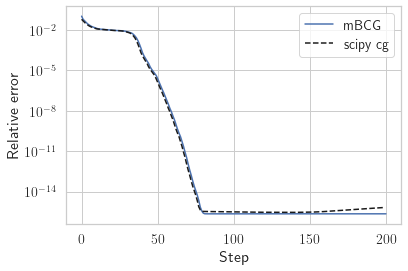

In [65]:
# === Generate the matrix A from its eigendecomposition
# Size of the matrix
n = 100
# Generate random orthogonal matrix
Q = torch.from_numpy(ortho_group.rvs(n))
# Generate eigenvalues
eigs = torch.linspace(1, 1e3, n)
#eigs = torch.linspace(1, 1e3, n)
# Compute A explicitly
A = Q @ torch.diag(eigs) @ Q.T

# === Generate solution and then the RHS of equation Ax = b
x = torch.randn(n)
b = A @ x

# === Approximation with iterative methods
# Starting solution for iterative methods
x0 = torch.zeros(n)
# Number of steps
k = 2*n

# mBCG algorithm
errors_mbcg = []
xk, _ = mbcg(lambda X: A@X, lambda X: X, b, torch.zeros_like(b), k, callback=callback(errors_mbcg, x))

# scipy reference algorithm
errors_sp = []
sp_cg(A.numpy(), b.numpy(), x0.numpy(), tol=1e-16, maxiter=k, callback=callback(errors_sp, x.numpy()));

# === Plot the errors
plt.semilogy(errors_mbcg, label='mBCG')
plt.semilogy(errors_sp, '--k', label='scipy cg')
plt.legend()
plt.xlabel('Step'); plt.ylabel('Relative error');